In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_334935/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
import os
os.chdir('../')
import torch
import pandas as pd
import numpy as np
import yaml
from sklearn import decomposition
from harmony import harmonize
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from tqdm import tqdm
import utils.label_dict
from utils.label_dict import protein_to_num_full
from utils.label_dict import hierarchical_organization_single_cell_low_level, hierarchical_organization_single_cell_high_level
from utils.label_dict import hierarchical_organization_whole_image_low_level, hierarchical_organization_whole_image_high_level
from utils.analysis_utils import plot_UMAP, get_embeddings, create_cell_comparison, create_protein_hierarchy


### Create UMAPs

In [4]:
from sklearn.metrics import mutual_info_score

def create_bins(x):
    unique_xs = sorted(np.unique(x))
    bins = [unique_xs[0] - 0.5]
    for ind in range(len(unique_xs) - 1):
        bins.append(unique_xs[ind] + (unique_xs[ind + 1] - unique_xs[ind]) / 2)
    bins = bins + [unique_xs[-1] + 0.5]  
    return bins

def mutual_info(x,y,code_bin, factor_bin):
    c_xy = np.histogram2d(x,y,(code_bin, factor_bin))[0]
    mi = 0
    N = np.sum(c_xy)
    for i in range(c_xy.shape[0]):
        for j in range(c_xy.shape[1]):
            p_i = np.sum(c_xy[i,:]) / N
            p_j = np.sum(c_xy[:,j]) / N
            p_ij = c_xy[i,j] / N
            if p_ij == 0: 
                mi += 0 
            else:
                mi += (p_ij) * np.log(p_ij / (p_i * p_j))
    return mi

def conditional_mutual_info(x,y,z,bins):
    c_xyz = np.histogramdd((x, 
                          y, 
                          z),
                          bins)[0]
    N = np.sum(c_xyz)
    mi = 0
    p_z = c_xyz.sum(axis=(0,1)) / N
    p_iz = c_xyz.sum(axis=(1)) / N
    p_jz = c_xyz.sum(axis=(0)) / N
    p_ijzs = c_xyz / N
    N = np.sum(c_xyz)
    for i in (range(c_xyz.shape[0])):
        for j in range(c_xyz.shape[1]):
            for z in range(c_xyz.shape[2]):
                if p_ijzs[i,j,z] == 0: 
                    mi += 0 
                else:
                    mi += (p_ijzs[i,j,z]) * np.log((p_z[z] * p_ijzs[i,j,z]) / (p_iz[i,z] * p_jz[j,z]))
    return mi    


def MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

def get_col_matrix(df, labels):
    if len(labels) == 1:
        values = df[labels[0]]
        unique_values = sorted(np.unique(values))
        mat = np.zeros((len(df), len(unique_values)))
        for ind, value in enumerate(unique_values):
            mat[np.where(values == value)[0], ind] = 1
        columns = unique_values
    else:
        mat = df[sorted(labels)].values.astype(int)
        columns = sorted(labels)
    return mat, columns

In [7]:
embedding

UMAP_1     UMAP_2
0      -14.328590 -10.398324
1      -14.977192 -10.265456
2       13.438740  15.927193
3       13.878462  17.346966
4      -16.806204   9.091037
...           ...        ...
117878  13.359716  -6.184863
117879  11.107221  -1.429197
117880  31.051903 -26.846312
117881  30.350204 -26.031130
117882  11.643280  -1.259664

[117883 rows x 2 columns]

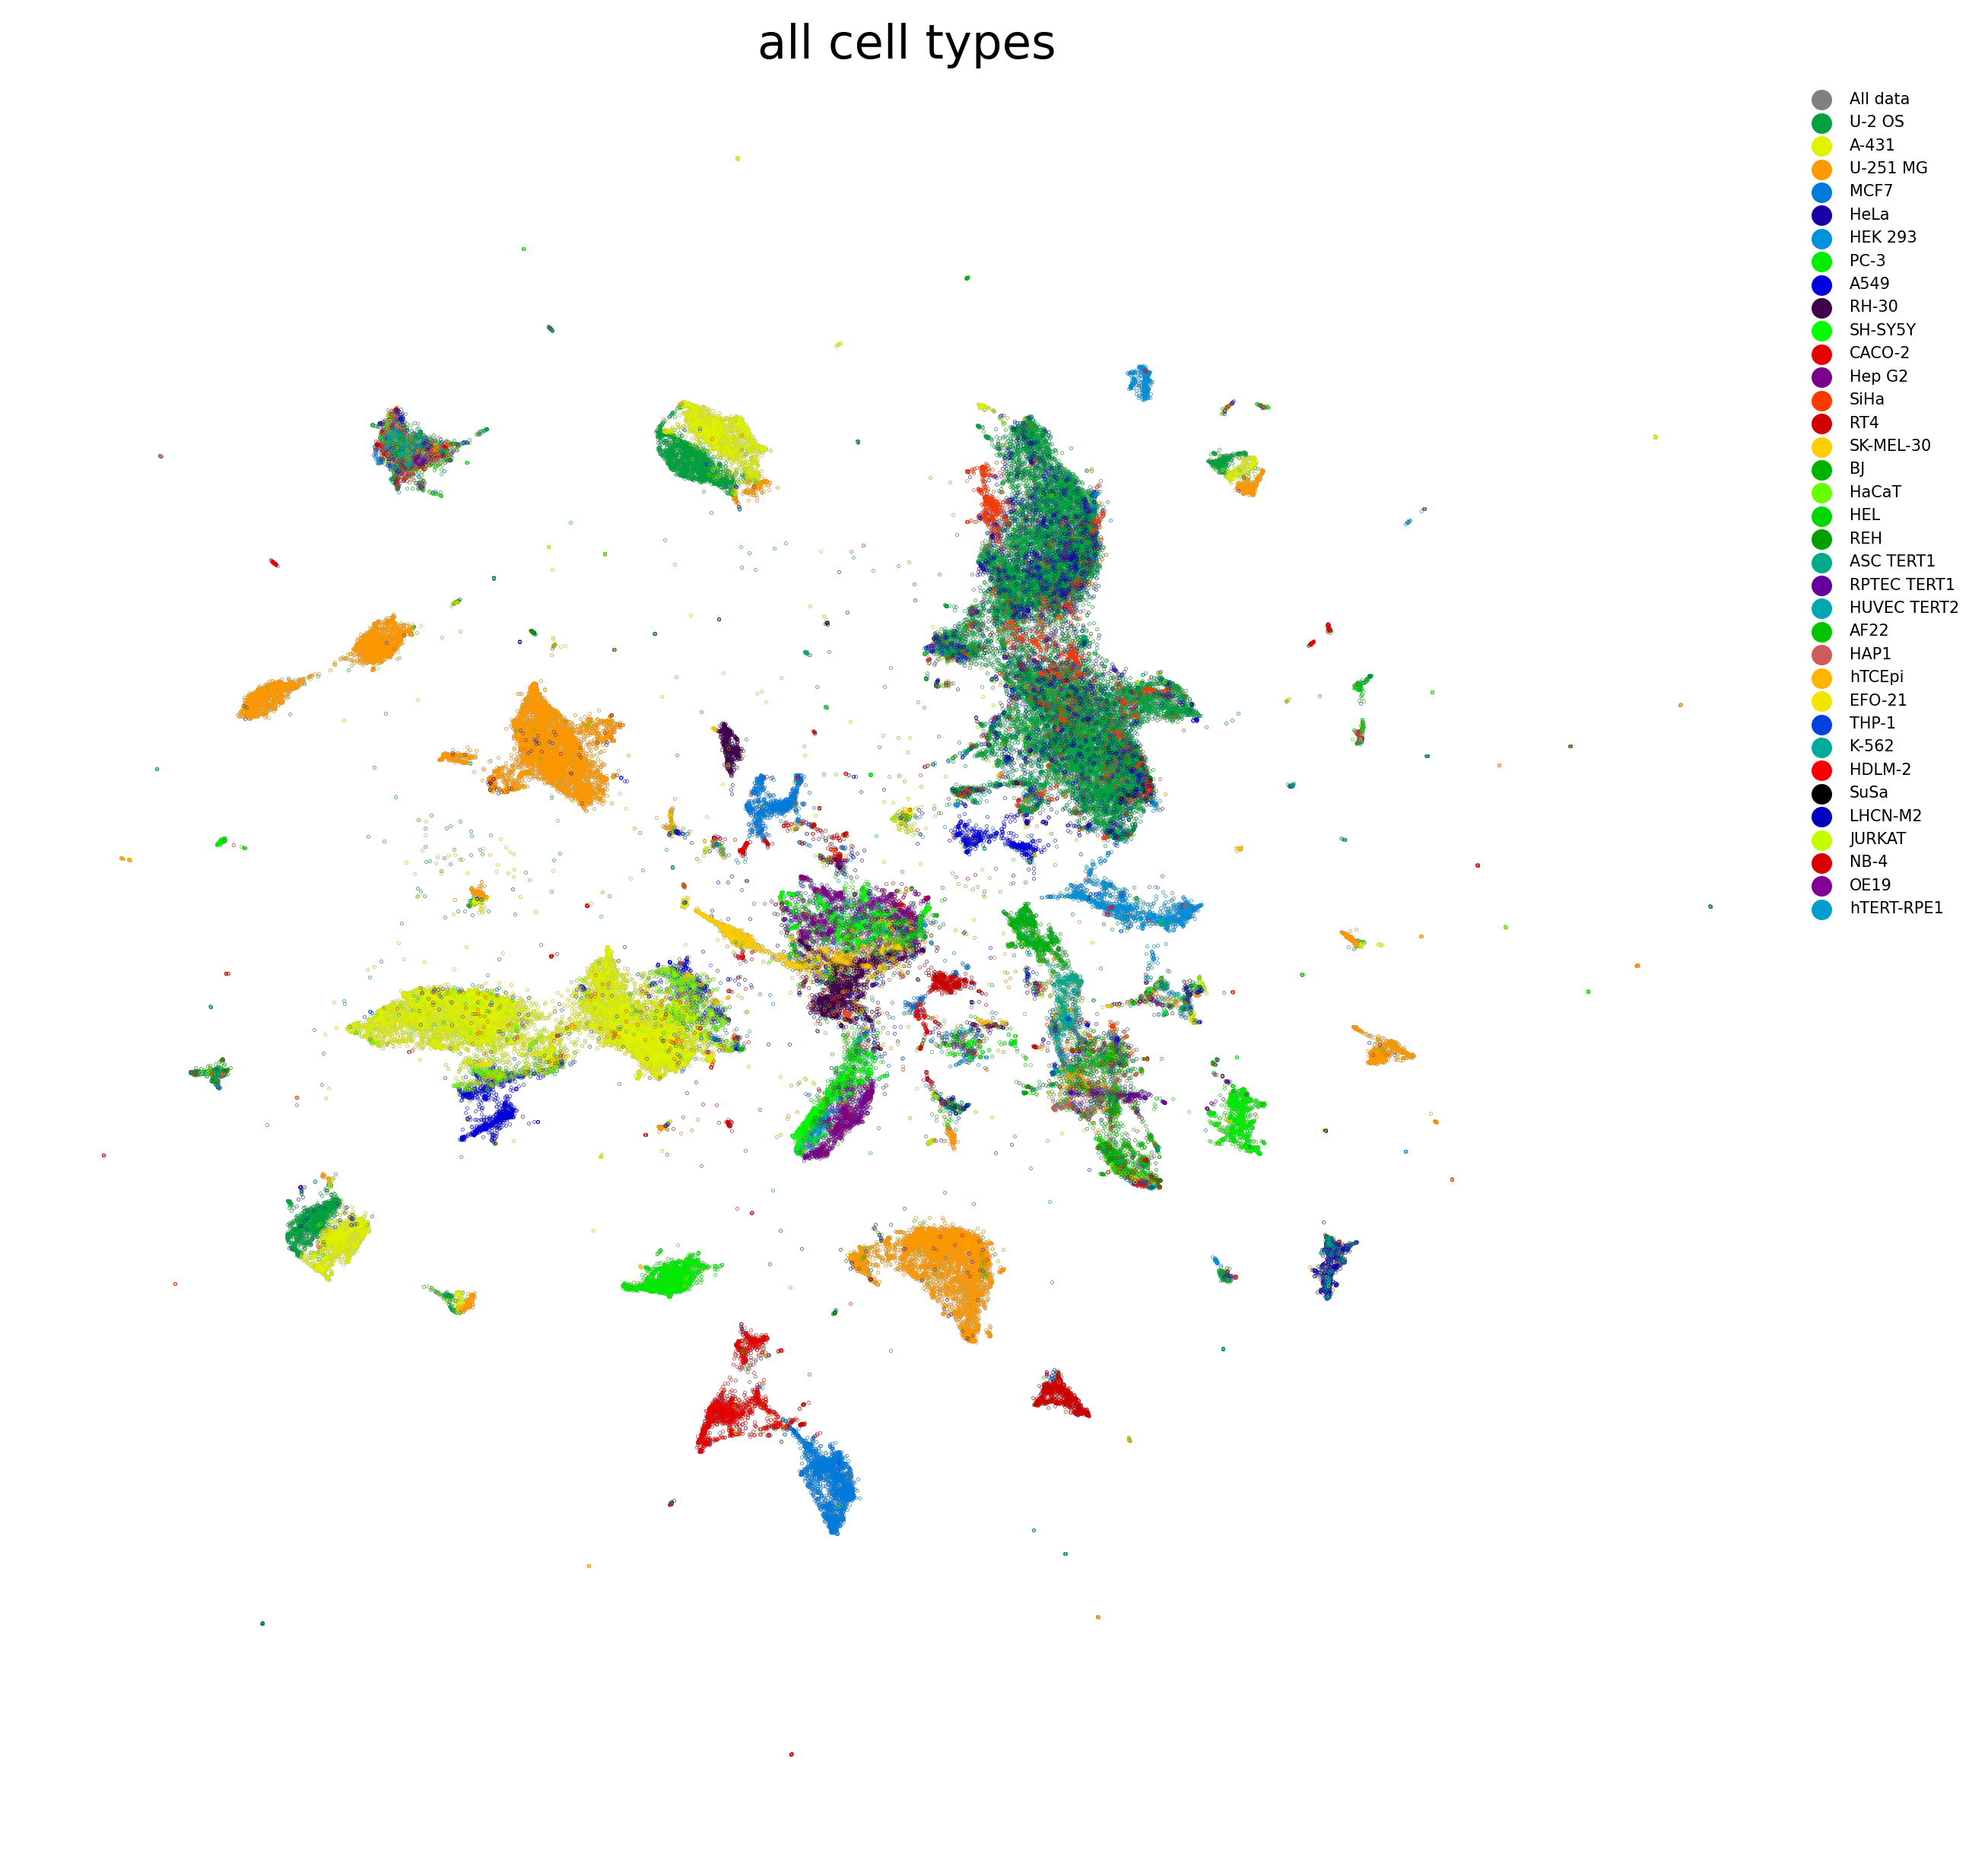

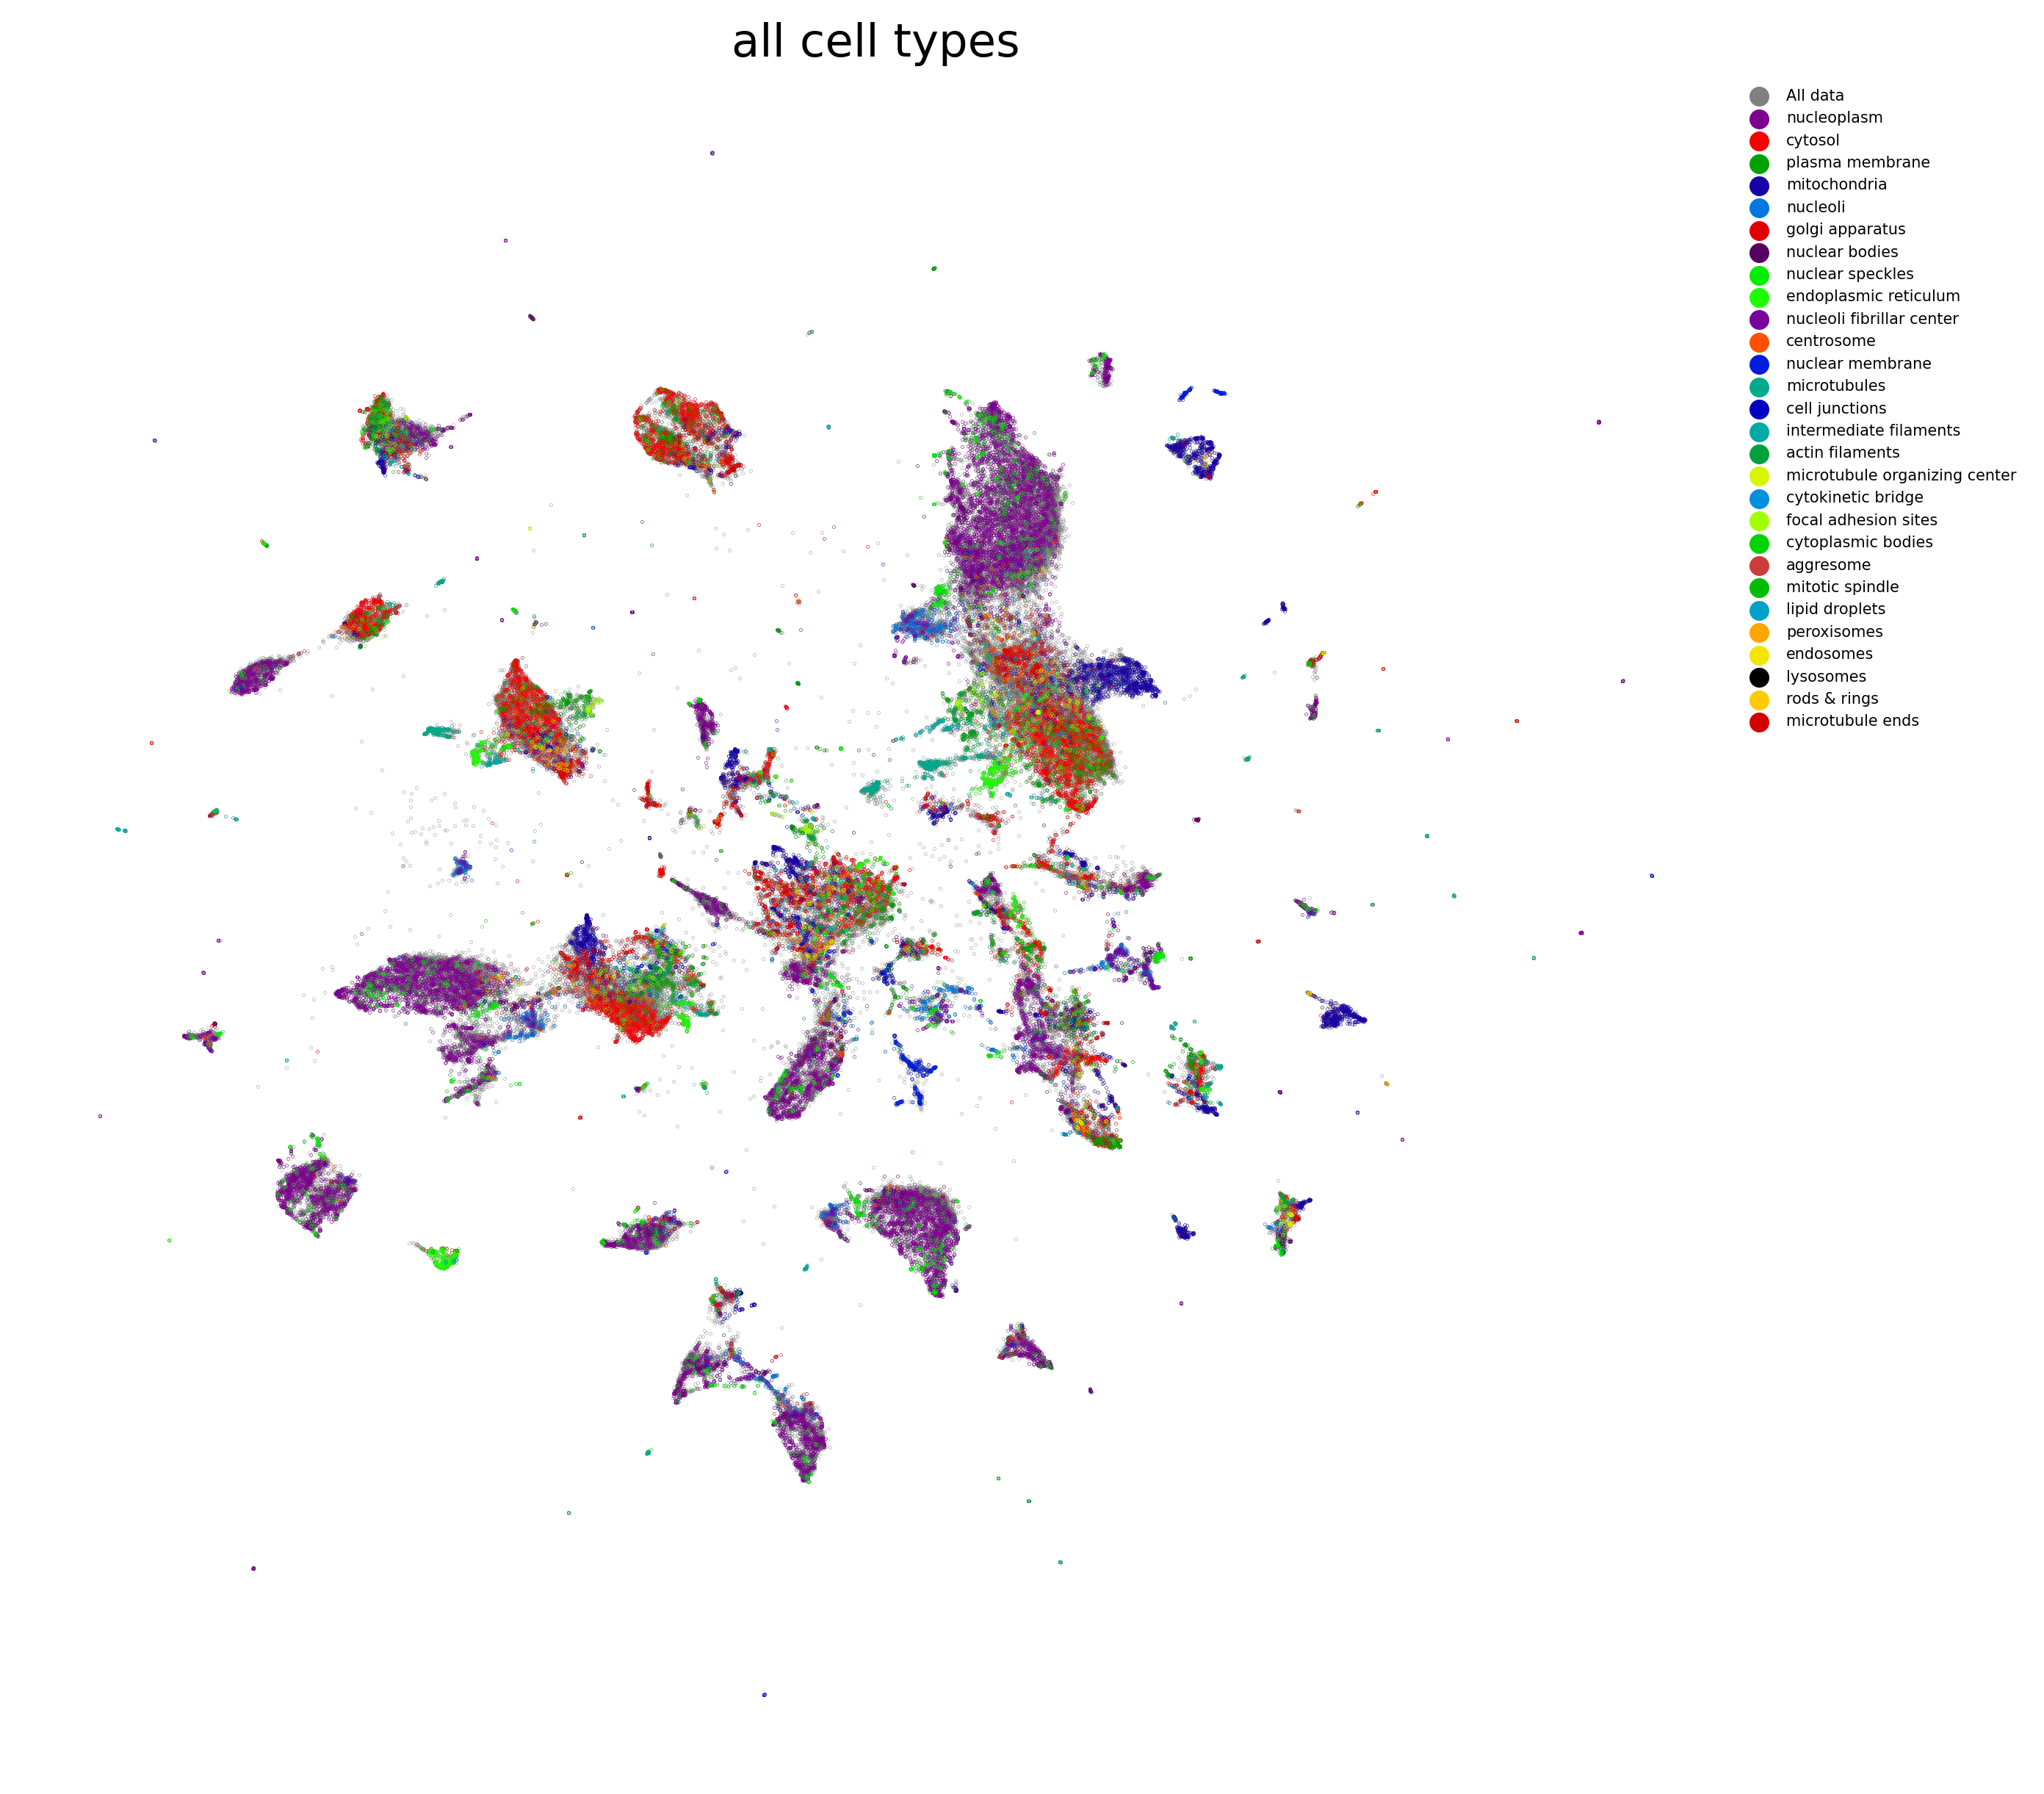

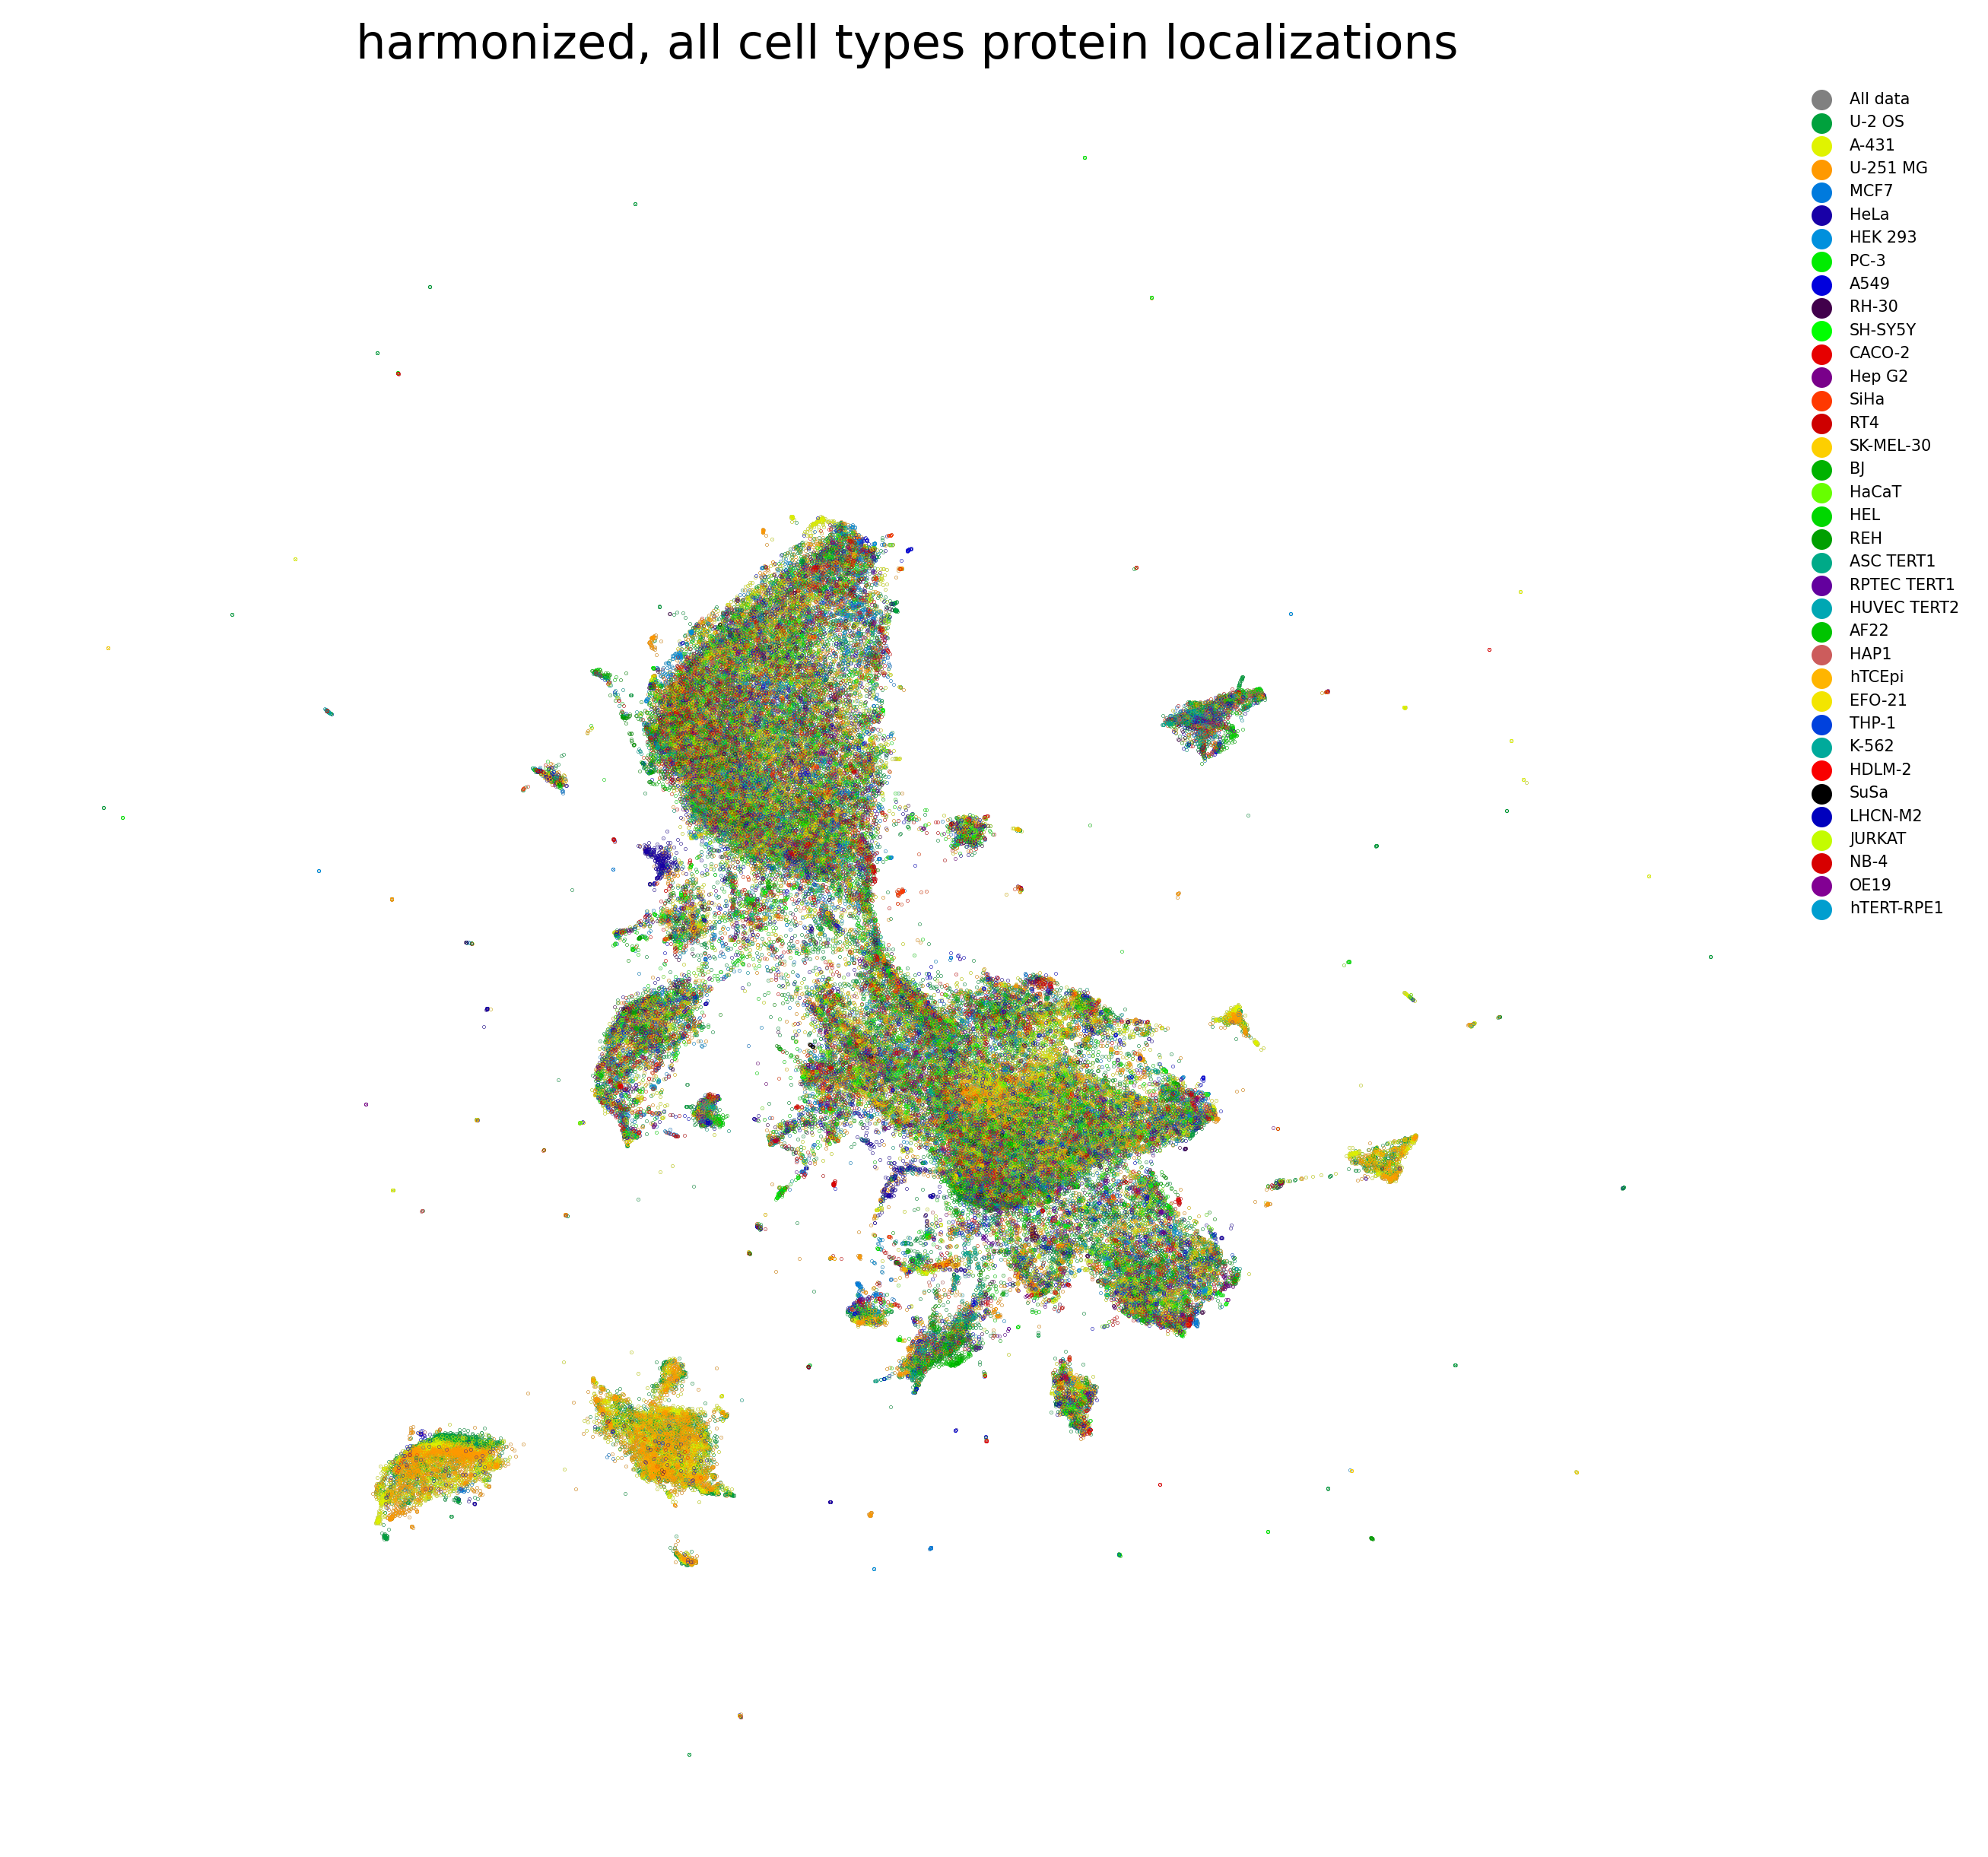

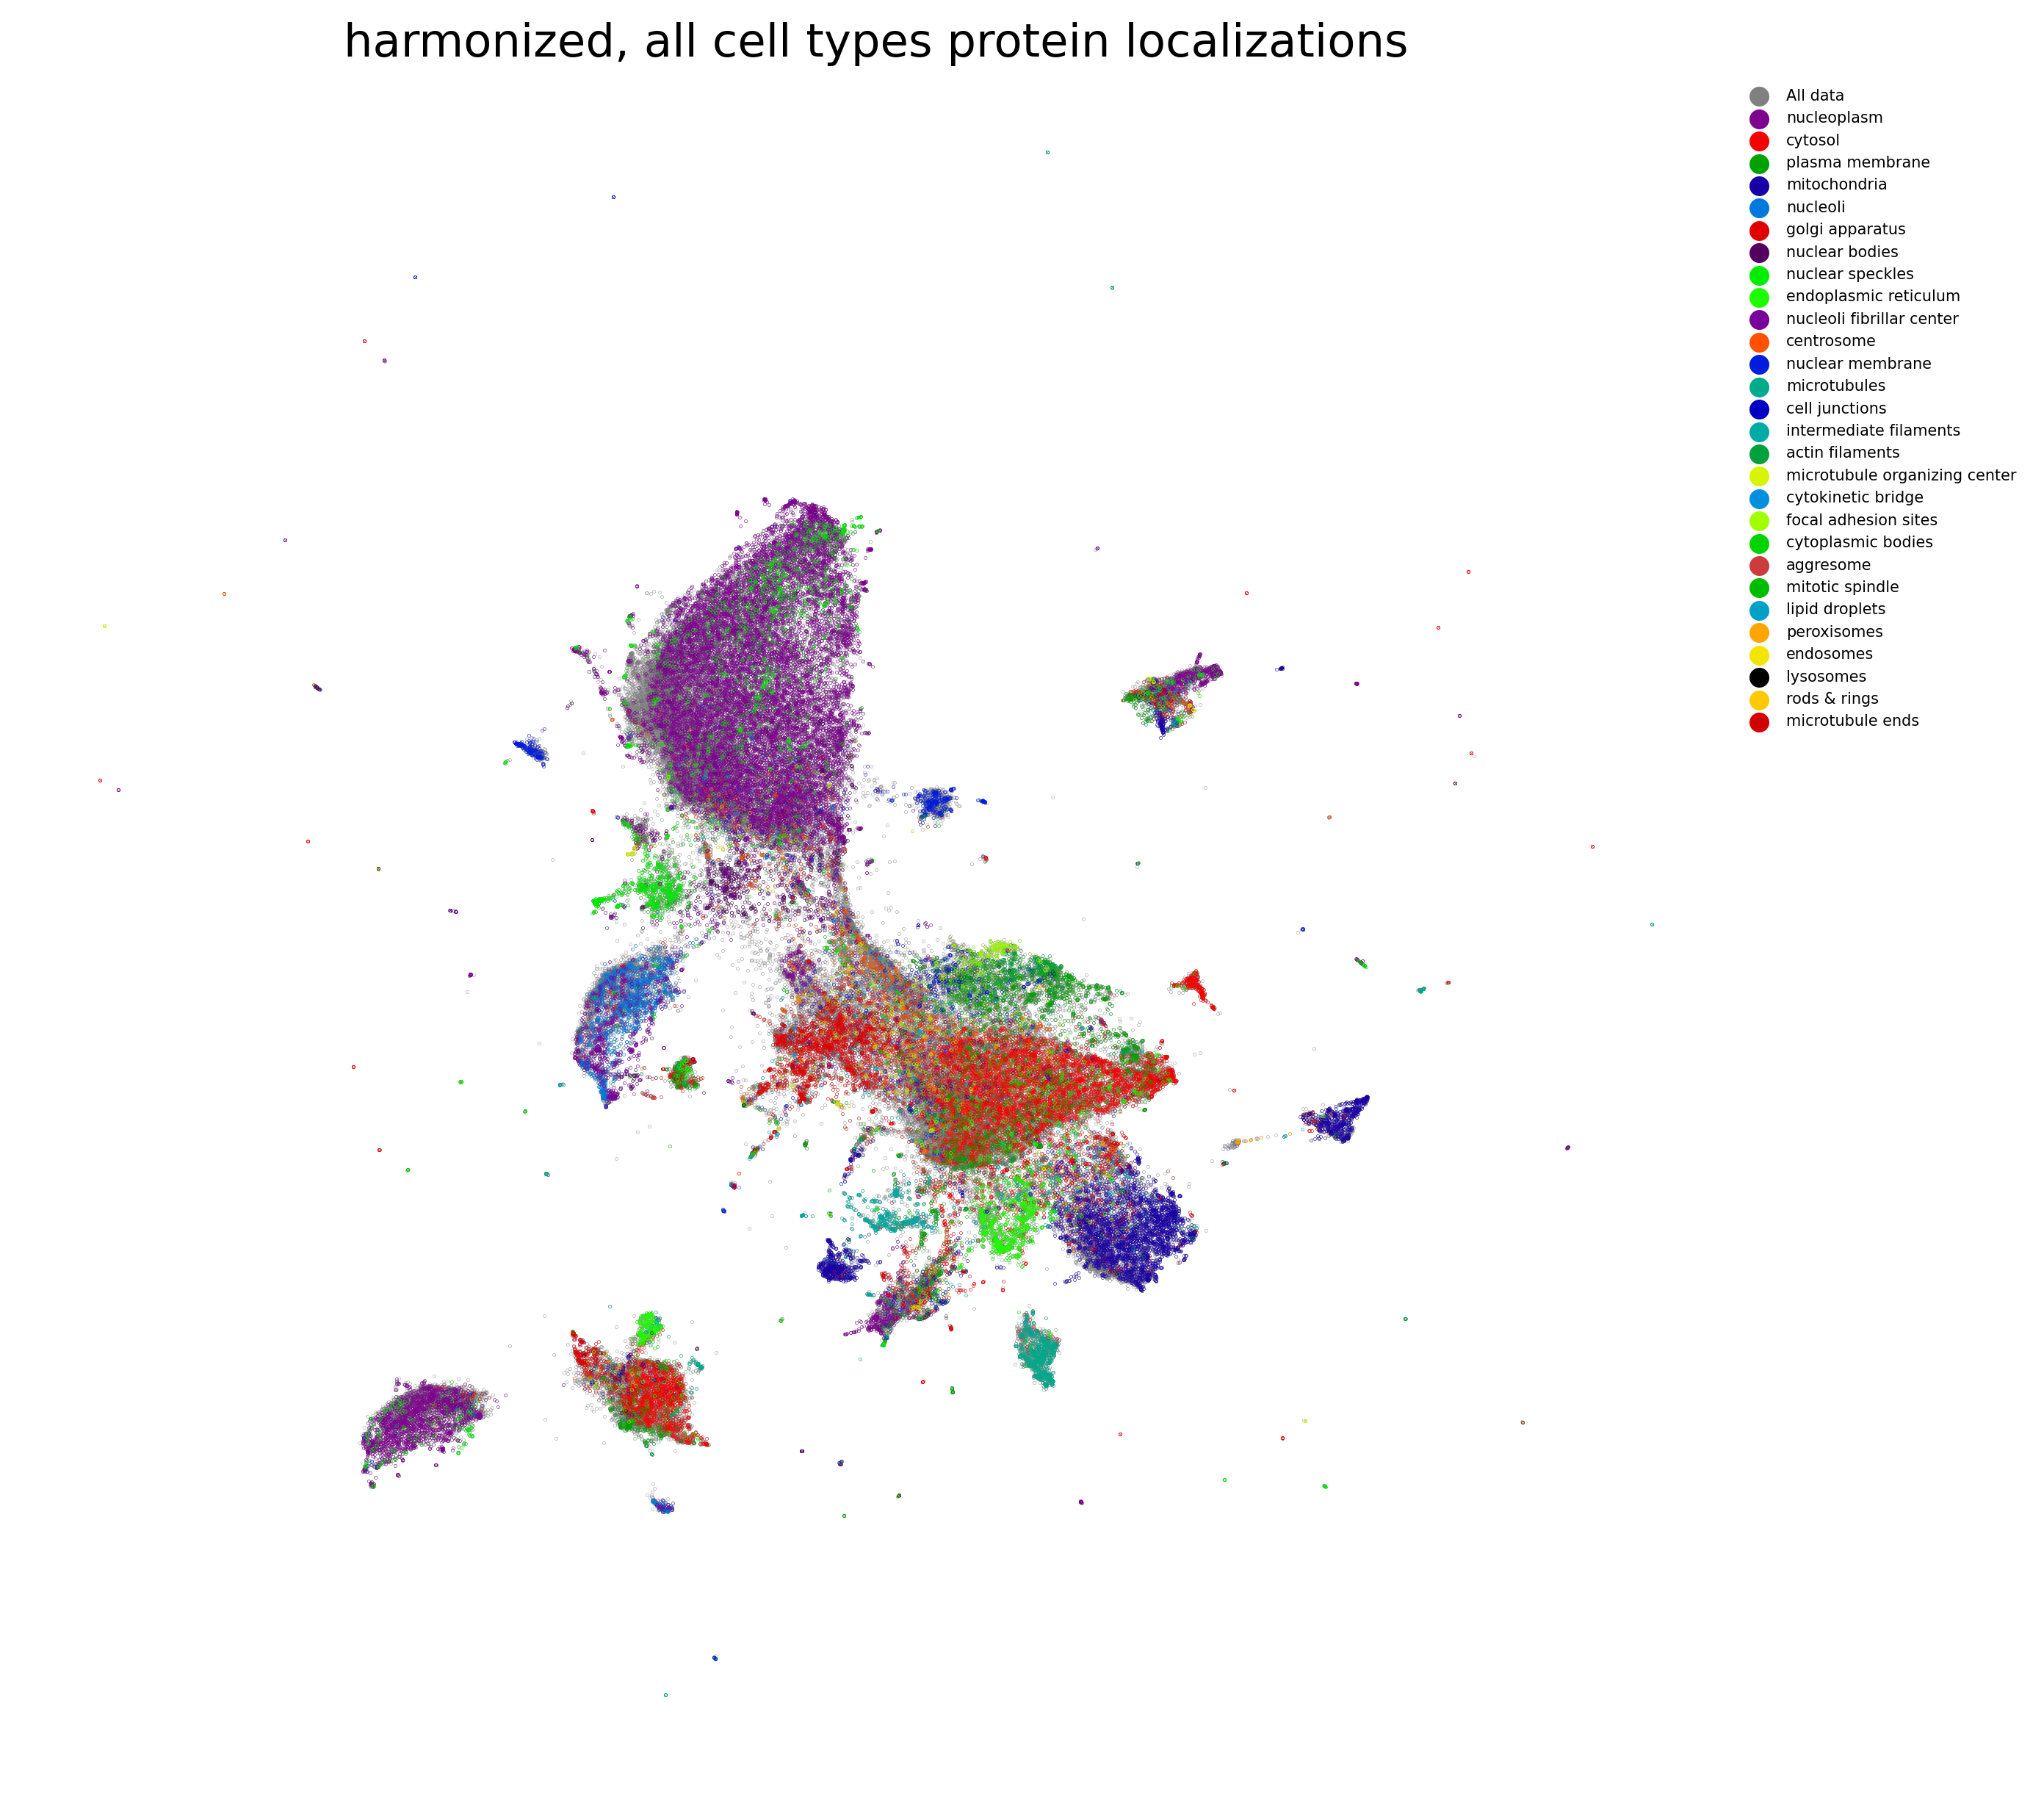

In [9]:
features, protein_localizations, cell_lines, IDs, df = torch.load('HPA_FOV_data/DINO_features_for_HPA_FOV.pth')
protein_labels = protein_to_num_full
# harmonized_features = harmonize(torch.Tensor(features).numpy(), 
#                                 df,
#                                 batch_key = ['cell_type'], 
#                                 use_gpu=True,
#                                 random_state=42,
# )
# one_protein_indices = np.where(protein_localizations.sum(axis=1) == 1)[0]
# features_to_fit = features[one_protein_indices]
# features_to_extract = features
# harmonized_features_to_fit = harmonized_features[one_protein_indices]
# harmonized_features_to_extract = harmonized_features

# umap_reducer, features_mean, features_std, harmonized_embedding, scaled_features = get_embeddings(torch.Tensor(harmonized_features_to_fit), torch.Tensor(harmonized_features_to_extract)) 
# umap_reducer, features_mean, features_std, embedding, scaled_features = get_embeddings(torch.Tensor(features_to_fit), torch.Tensor(features_to_extract)) 

embedding = pd.read_csv('HPA_FOV_data/DINO_FOV_embeddings.csv')[['UMAP_1','UMAP_2']].values
harmonized_embedding = pd.read_csv('HPA_FOV_data/DINO_FOV_harmonized_embeddings.csv')[['UMAP_1','UMAP_2']].values

cell_color_indices = torch.load('HPA_FOV_data/whole_image_cell_color_indices.pth')
protein_color_indices = torch.load('HPA_FOV_data/whole_image_protein_color_indices.pth')

plot_UMAP(df, ['cell_type'], embedding,  f'all cell types', 'results/HPA_FOV/HPA_FOV_cell_types.pdf', cell_color_indices)
plot_UMAP(df, protein_labels, embedding,  f'all cell types', 'results/HPA_FOV/HPA_FOV_protein_localizations.pdf', protein_color_indices)
plot_UMAP(df, ['cell_type'], harmonized_embedding,  f'harmonized, all cell types protein localizations', 'results/HPA_FOV/HPA_FOV_cell_types_harmonized.pdf', cell_color_indices)
plot_UMAP(df, protein_labels, harmonized_embedding,  f'harmonized, all cell types protein localizations', 'results/HPA_FOV/HPA_FOV_protein_localizations_harmonized.pdf', protein_color_indices)


### Plot Kaggle results

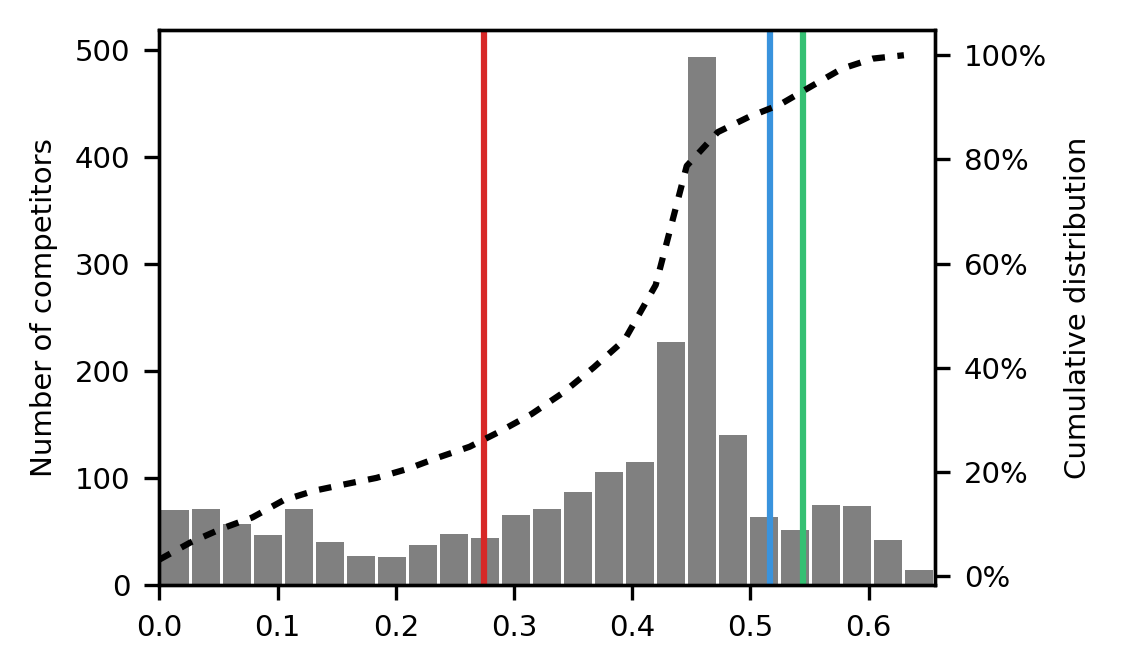

In [6]:
# os.chdir('Dino4Cells_analysis/')
whole_image_leaderboard = pd.read_csv('HPA_FOV_data/human-protein-atlas-image-classification-publicleaderboard.csv')
font = {'size'   : 7}
matplotlib.rc('font', **font)

fig, axis = plt.subplots(1,1,figsize=(2.5 * 1.5,1.5 * 1.5), dpi=300)

values = plt.hist(whole_image_leaderboard.Score, bins=25, label='Frequency', rwidth=0.9, color='grey')
cumulative = np.cumsum(values[0])
cumulative /= cumulative.max()
cumulative *= 100

DINO = 0.51687
Kaggle =  0.54423
pretrained = 0.27497

lw = 1.5
plt.axvline(x=DINO, color='#3993dd', label='DINO', linewidth=lw)
plt.axvline(x=Kaggle, color='#35c073', label='Kaggle', linewidth=lw)
plt.axvline(x=pretrained, color='#d72827', label='Pretrained', linewidth=lw)
plt.axis([whole_image_leaderboard.Score.min(), whole_image_leaderboard.Score.max(), 0, np.max(values[0]) + 25])
ax2 = axis.twinx()
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.plot(values[1][:-1], cumulative, color='black', dashes=[2], label='Cumulative', linewidth=lw)
plt.xlabel('Performance on test')
axis.set_ylabel('Number of competitors')
axis.set_yticks([0, 100, 200, 300, 400, 500])
ax2.set_ylabel('Cumulative distribution')
plt.tight_layout()
plt.savefig('results/HPA_FOV/HPA_FOV_Kaggle.pdf')

### Plot Cell Type classification

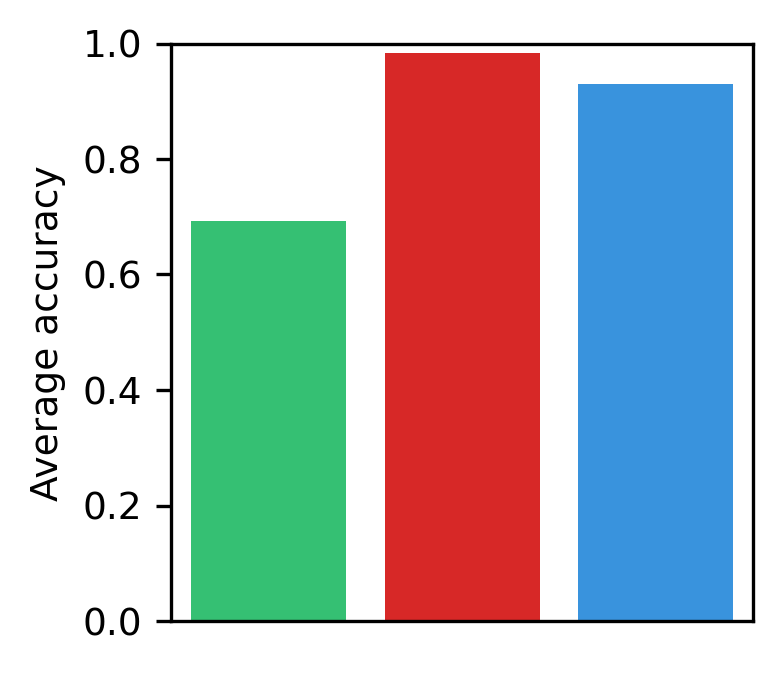

In [7]:
cells_DINO =  0.93
cells_Bestfitting = 0.6920088266191581
cells_Pretrained = 0.9834303297769443

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
font = {'size'   : 9}
matplotlib.rc('font', **font)
from sklearn.metrics import confusion_matrix
import pandas as pd
import torch

fig, axis = plt.subplots(1,1,figsize=(2.5,2.5), dpi=300)
plt.bar(x=[0], height=[cells_Bestfitting], color='#35c073')
plt.bar(x=[1], height=[cells_Pretrained], color='#d72827')
plt.bar(x=[2], height=[cells_DINO], color='#3993dd')
plt.ylabel('Average accuracy')
plt.xticks([])
plt.axis([-0.5, 2.5, 0, 1])
plt.savefig('results/HPA_FOV/HPA_FOV_Cell_type.pdf')

0.7354135008935471


cell line / RNASeq mantel test: MantelResult(0.45711951820390506, 0.0001, 10.873677237386946)
protein CC knn, top-1: 0.37142857142857144
[0 0 1 0 1 1 1 0 1 1 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0]


protein hierarchy mantel test: MantelResult(0.5293464805047168, 0.0001, 6.220214276334516)


0.5293464805047168

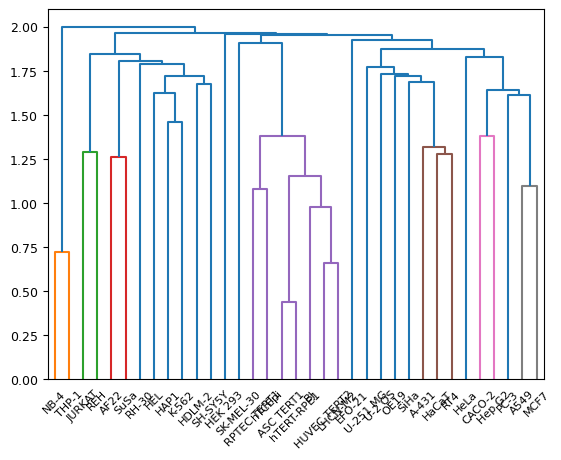

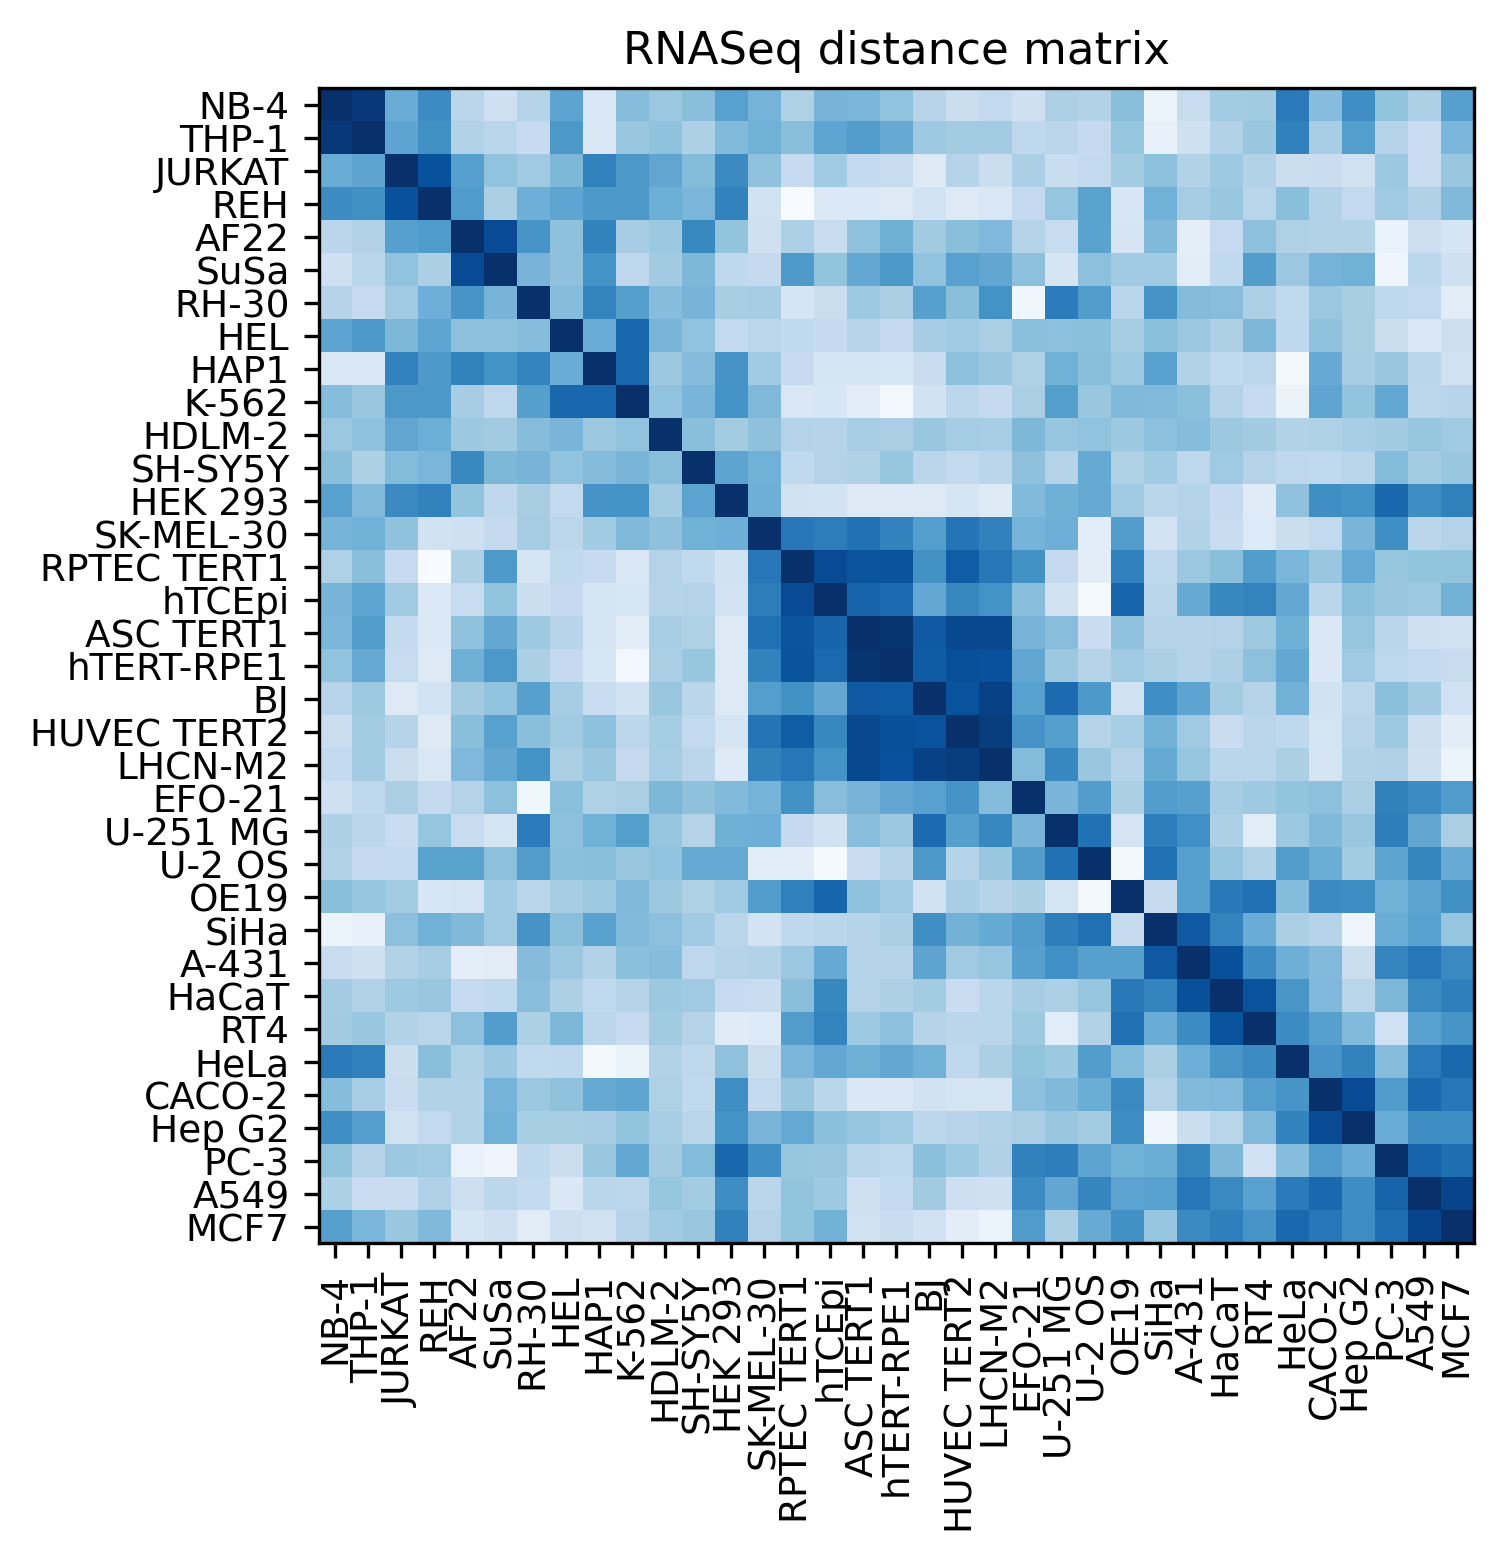

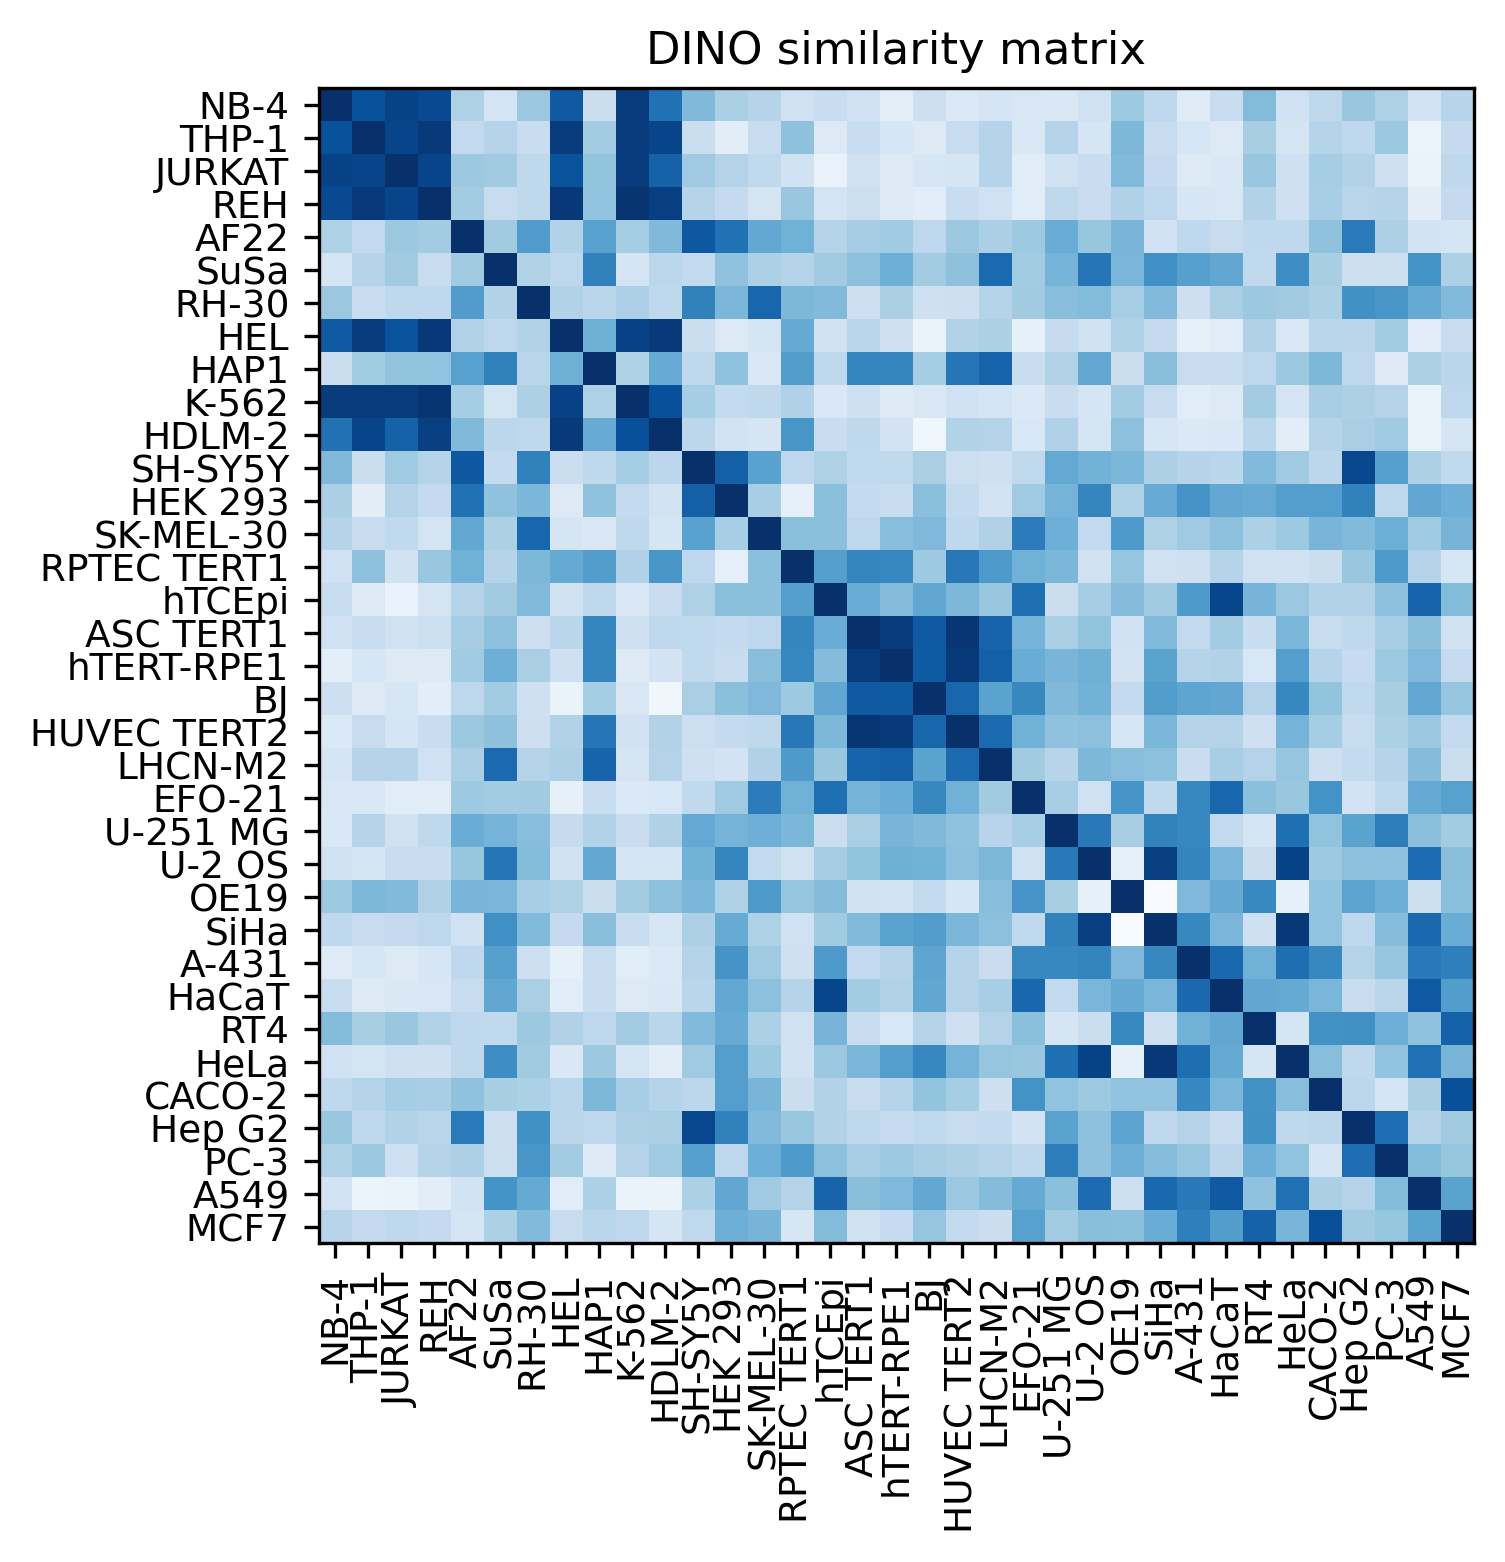

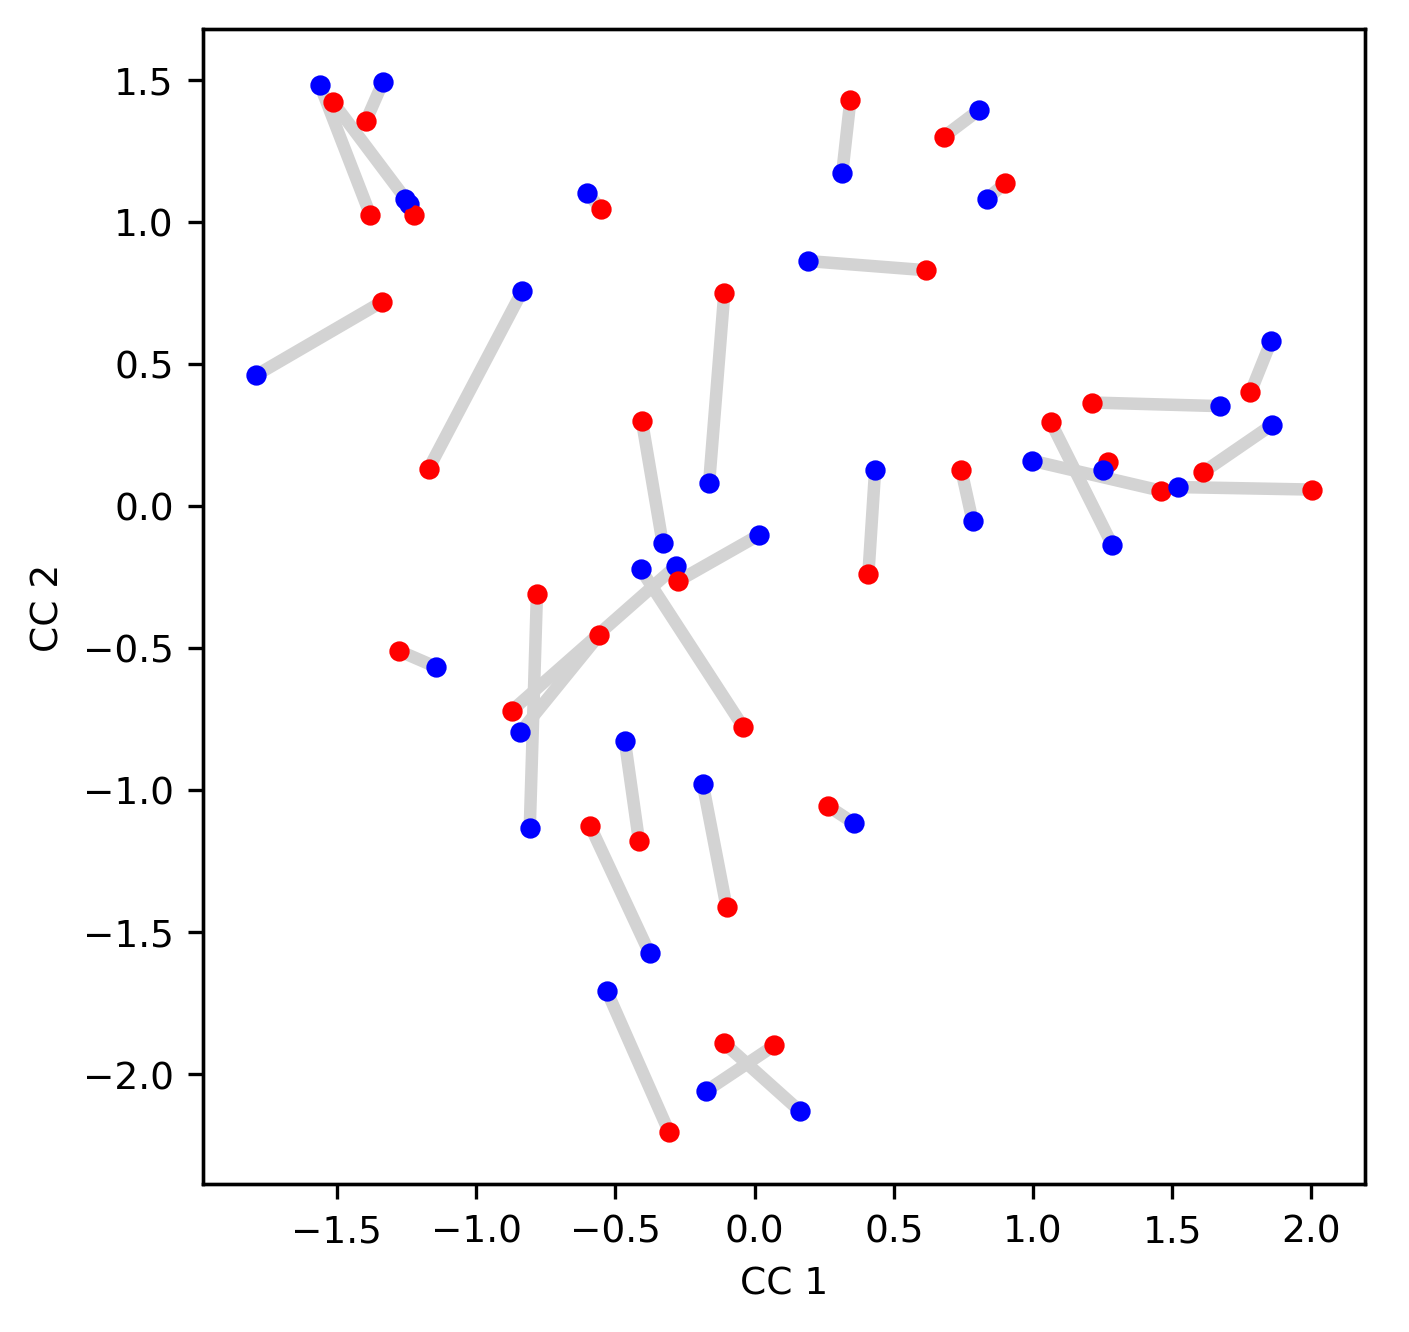

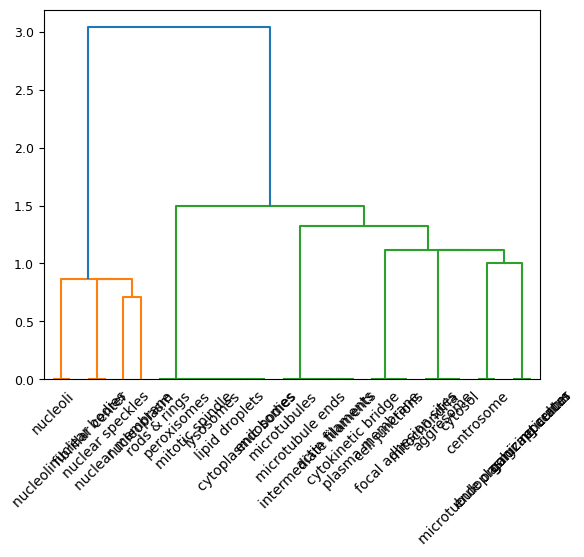

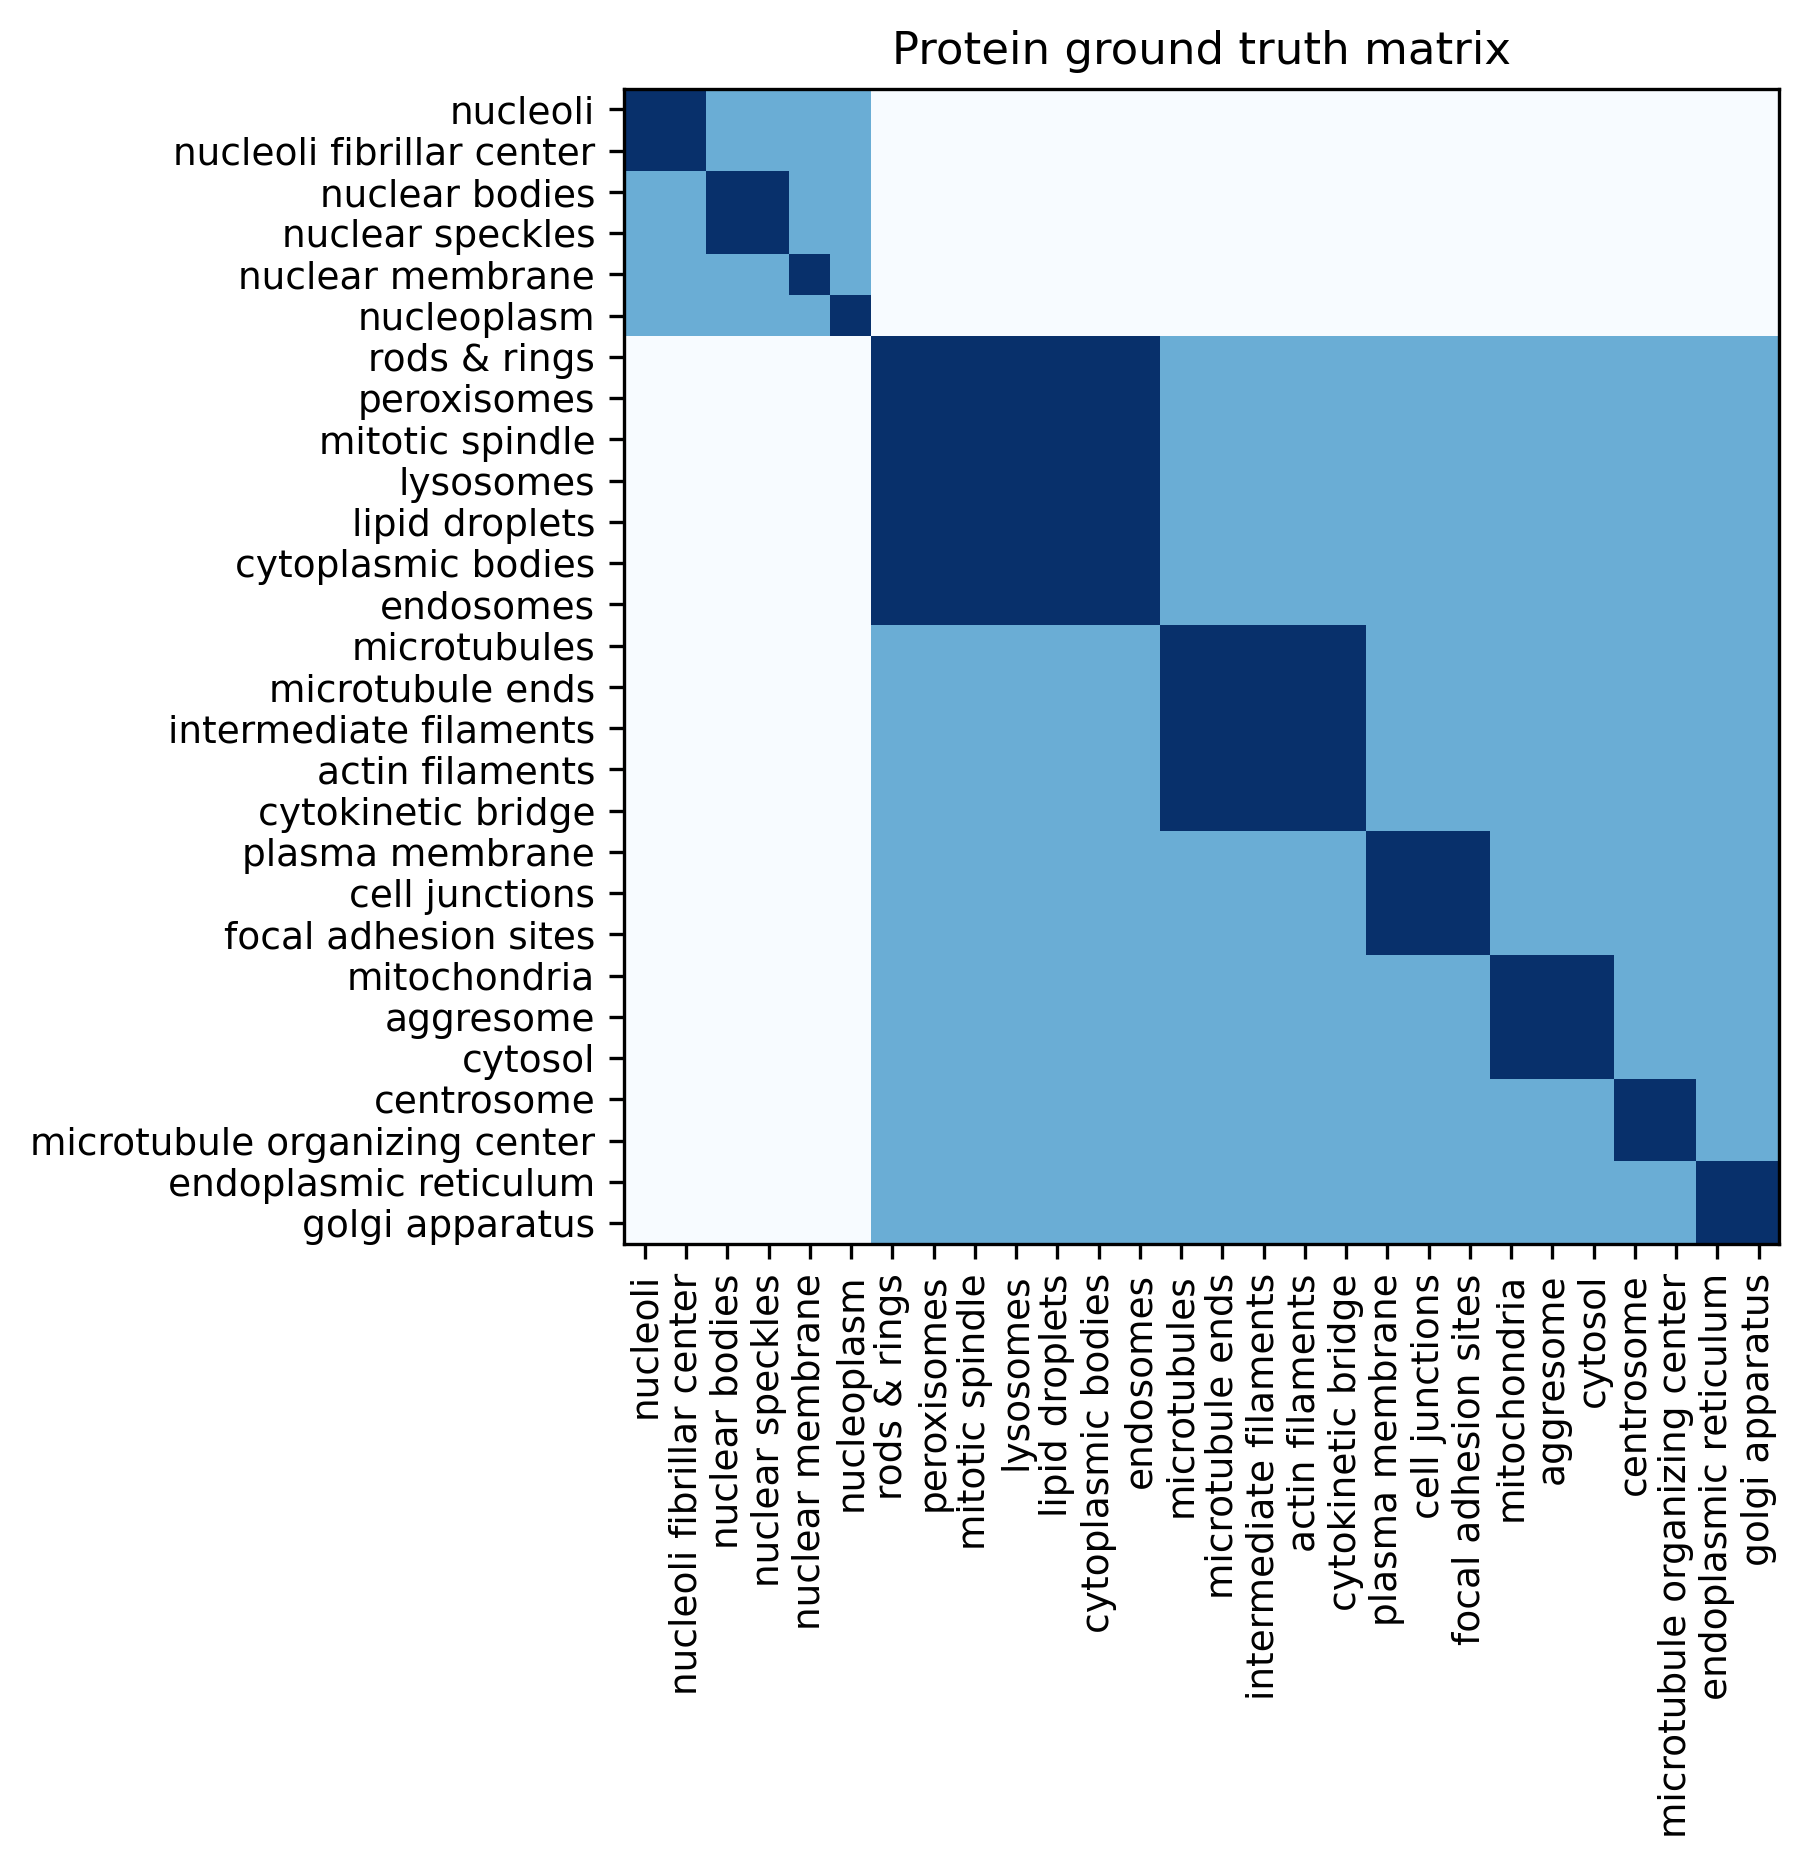

<Figure size 640x480 with 0 Axes>

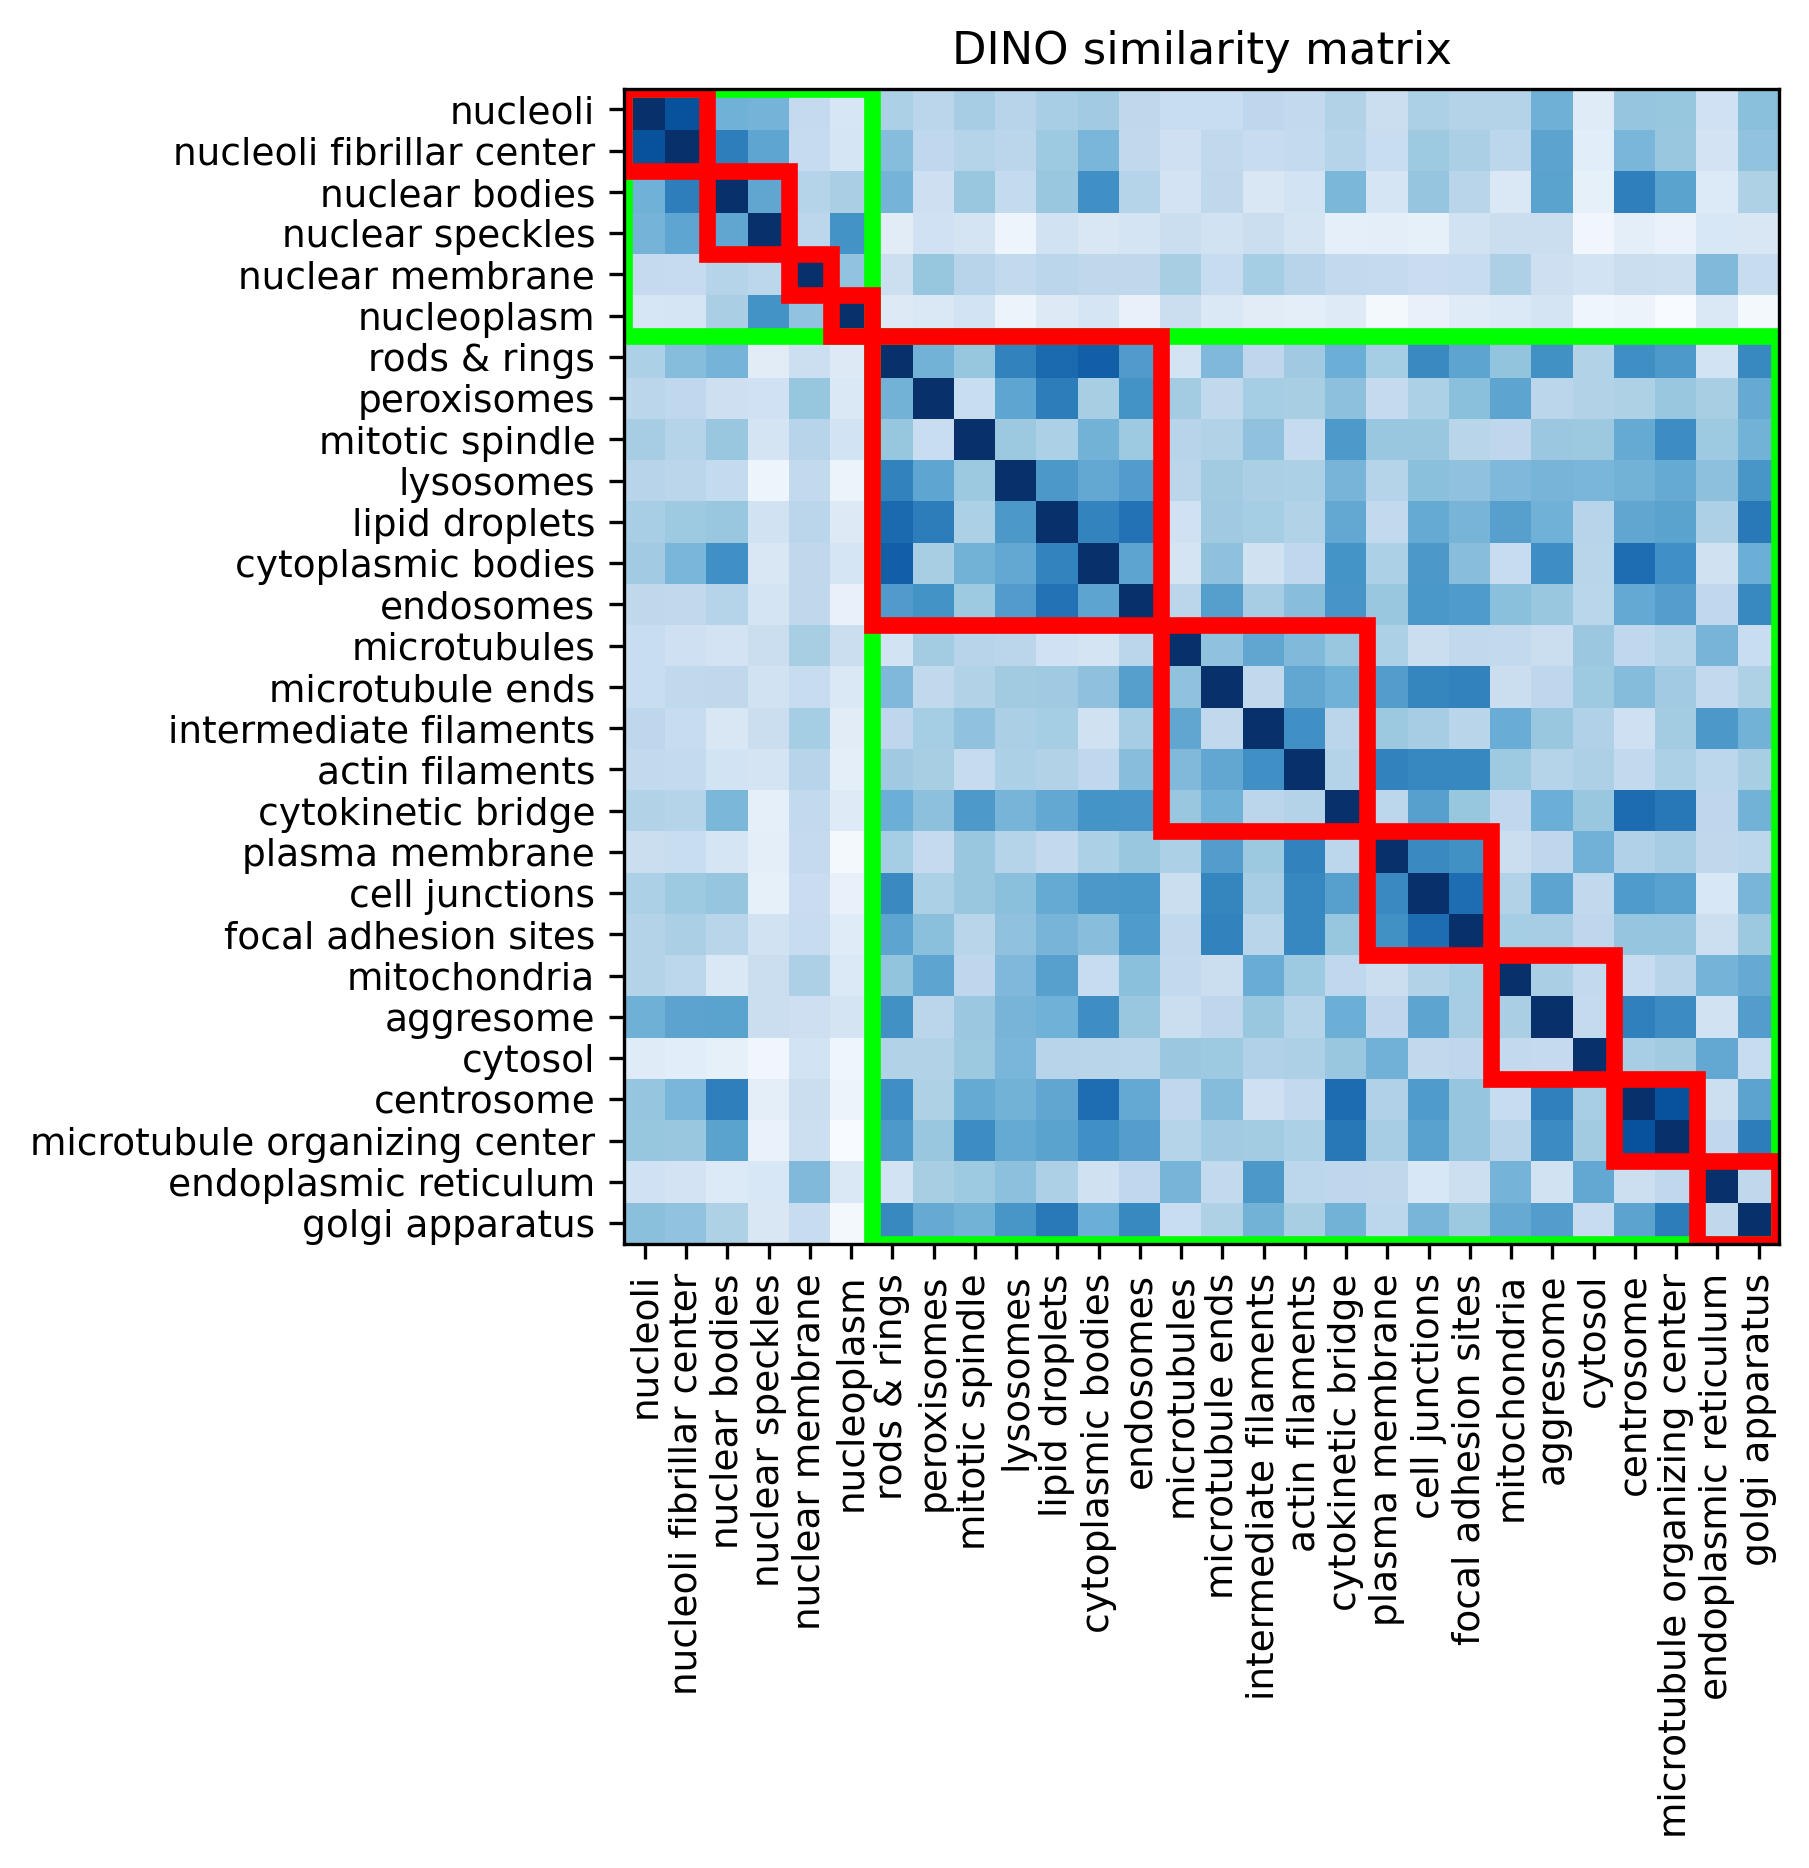

In [8]:
path_to_rna = 'HPA_FOV_data/rna_cellline.tsv'
rna = pd.read_csv(path_to_rna, delimiter="\t")
from matplotlib import cm
cmap = cm.nipy_spectral

create_cell_comparison(features, protein_localizations, cell_lines, IDs, df, rna, 'results/HPA_FOV/')
create_protein_hierarchy(features, protein_localizations, cell_lines, IDs, df, 'results/HPA_FOV/')

(200000.0, 20000000.0, 0.0, 0.7)

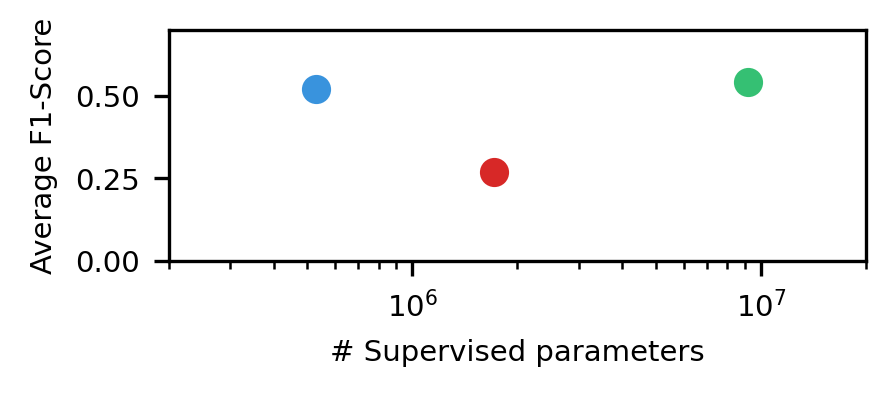

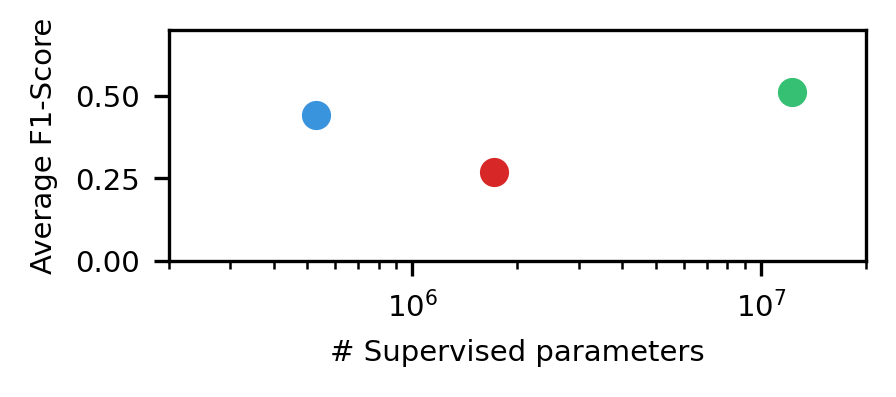

In [15]:
DINO_params = 529939
Kaggle_params =  9157346
pretrained_params = 1709587
supervised_params = 86389276
supervised = 0.43535
DINO = 0.52
Kaggle =  0.54
pretrained = 0.27

fig, axis = plt.subplots(1,1,figsize=(3,1), dpi=300)

plt.scatter(DINO_params, DINO, color='#3993dd')
plt.scatter(Kaggle_params, Kaggle, color='#35c073')
plt.scatter(pretrained_params, pretrained, color='#d72827')
plt.xlabel('# Supervised parameters', fontsize=7)
plt.ylabel('Average F1-Score', fontsize=7)
axis.set_xscale('log')
plt.axis([200000, 20000000, 0, 0.7])

DINO_params = 529939
Kaggle_params =  12233593
pretrained_params = 1709587
DINO = 0.44
Kaggle =  0.51
pretrained = 0.27

fig, axis = plt.subplots(1,1,figsize=(3,1), dpi=300)

plt.scatter(DINO_params, DINO, color='#3993dd')
plt.scatter(Kaggle_params, Kaggle, color='#35c073')
plt.scatter(pretrained_params, pretrained, color='#d72827')
plt.xlabel('# Supervised parameters', fontsize=7)
plt.ylabel('Average F1-Score', fontsize=7)
axis.set_xscale('log')
plt.axis([200000, 20000000, 0, 0.7])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2304/2304 [00:55<00:00, 41.60it/s]


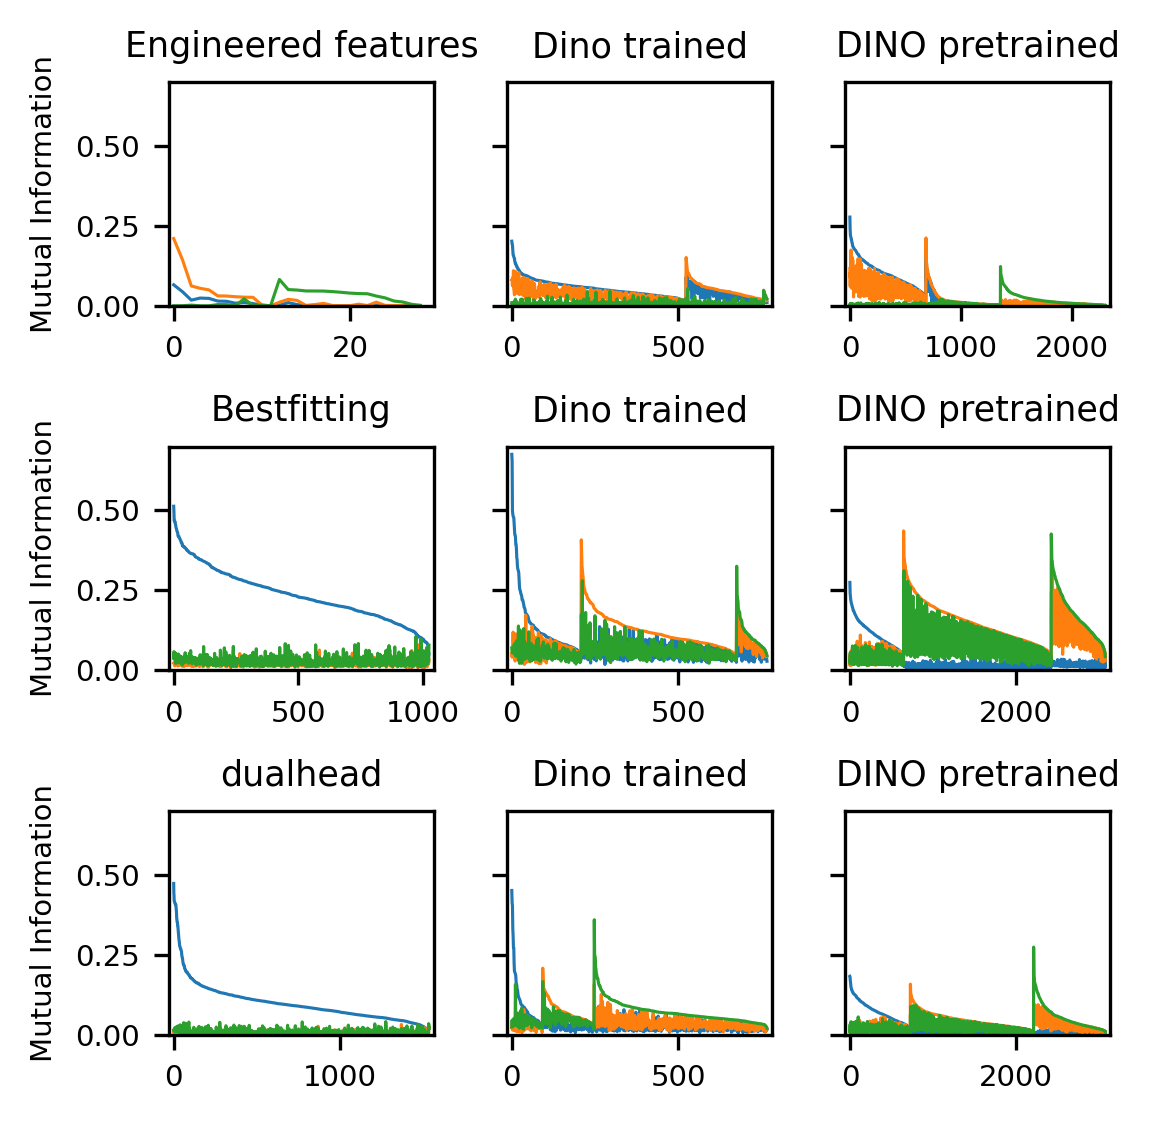

In [23]:
feature_files = [
    'HPA_FOV_data/bestfitting_features_for_HPA_FOV.pth',
    'HPA_FOV_data/DINO_features_for_HPA_FOV.pth',
    'HPA_FOV_data/pretrained_DINO_features_for_HPA_FOV.pth',
]

labels = [
    'Bestfitting',
    'Trained DINO',
    'Pretrained DINO',
             ]

whole_model_labels = labels
whole_mi_matrices = []
factor_gaps_per_method = []
code_bins = [25]
factor_bins = [25]
for code_bin, factor_bin in zip(code_bins, factor_bins):
    for feature_file, label in zip(feature_files, labels):
        features, protein_localizations, cell_lines, IDs, df = torch.load(feature_file)    
        try:
            protein_localizations = torch.stack(protein_localizations)
        except:
            pass
        protein_localizations = torch.Tensor(protein_localizations)

        one_protein_indices = np.where(protein_localizations.sum(axis=1) == 1)[0]
        website_indices = np.where(df.ID.str.contains('_'))[0]
        website_features = features[website_indices,:]
        website_df = df.iloc[website_indices].reset_index()
        website_df['plate'] = website_df.ID.str.split('_', expand=True)[0].values
        website_df['well'] = website_df.ID.str.split('_', expand=True)[1].values
        website_proteins = protein_localizations[website_indices]
        cell_mat, cell_labels = get_col_matrix(df, ['cell_type'])    
        website_cell = cell_mat[website_indices]
        one_protein_indices = np.where(website_proteins.sum(axis=1) == 1)[0]
        if 'harmonized' in label:
            website_features = harmonize(torch.Tensor(website_features).numpy(), 
                                            website_df,
                                            batch_key = ['cell_type'], 
                                            use_gpu=True,
                                            random_state=42,
            )        
        
        website_features -= website_features.min(axis=0)[0]
        website_features /= website_features.max(axis=0)[0]

        factors = np.stack((np.argmax(website_proteins[one_protein_indices], axis=1).numpy(),
                        np.argmax(website_cell[one_protein_indices], axis=1),
                        website_df['well'].values[one_protein_indices].astype(int))).T
        codes = torch.Tensor(website_features[one_protein_indices])

        whole_HPA_protein_MI = []
        whole_HPA_cell_MI = []
        whole_HPA_well_MI = []

        for i in tqdm(range(website_features.shape[1])):
            protein_mi = mutual_info(codes[:,i].numpy(), factors[:,0], code_bin, factor_bin)
            whole_HPA_protein_MI.append(protein_mi)
            cell_mi = mutual_info(codes[:,i].numpy(), factors[:,1], code_bin, factor_bin)
            whole_HPA_cell_MI.append(cell_mi)    
            well_mi = mutual_info(codes[:,i].numpy(), factors[:,2], code_bin, factor_bin)
            whole_HPA_well_MI.append(well_mi)      
        mi_matrix = np.stack((whole_HPA_protein_MI, whole_HPA_cell_MI, whole_HPA_well_MI))
    #     dcimig_score, mi_matrix = dcimig(factors, codes)
        highest_factor_mask = np.array(list(zip(np.argsort(mi_matrix, axis=0)[::-1][0,:], range(mi_matrix.shape[1])))).T
        second_highest_factor_mask = np.array(list(zip(np.argsort(mi_matrix, axis=0)[::-1][1,:], range(mi_matrix.shape[1])))).T
        gap = mi_matrix[highest_factor_mask[0,:],:].diagonal() - mi_matrix[second_highest_factor_mask[0,:],:].diagonal()
        factor_indices = [np.where(mi_matrix[i,:] >= np.max(mi_matrix, axis=0))[0] for i in range(factors.shape[1])]
        factor_gaps = [gap[f].max() if len(f) > 0 else 0 for f in factor_indices]
        factor_gaps_per_method.append(factor_gaps)
        whole_mi_matrices.append(mi_matrix)

feature_files = [
    'HPA_single_cells_data/dualhead_features_for_HPA_single_cells.pth',
    'HPA_single_cells_data/DINO_features_for_HPA_single_cells.pth',
    'HPA_single_cells_data/pretrained_DINO_features_for_HPA_single_cells.pth',
               ]
labels = [
    'Dualhead',
    'Trained DINO',
    'Pretrained DINO',
             ]

single_model_labels = labels
single_mi_matrices = []
factor_gaps_per_method = []
code_bins = [25]
factor_bins = [25]
for code_bin, factor_bin in zip(code_bins, factor_bins):
    for feature_file, label in zip(feature_files, labels):
        features, protein_localizations, cell_lines, IDs, df = torch.load(feature_file)    
        try:
            protein_localizations = torch.stack(protein_localizations)
        except:
            pass
        protein_localizations = torch.Tensor(protein_localizations)
                
        one_protein_indices = np.where(protein_localizations.sum(axis=1) == 1)[0]
        website_indices = np.where(df.ID.str.contains('_'))[0]
        website_features = features[website_indices,:]
        website_df = df.iloc[website_indices].reset_index()
        website_df['plate'] = website_df.ID.str.split('_', expand=True)[0].values
        website_df['well'] = website_df.ID.str.split('_', expand=True)[1].values
        website_proteins = protein_localizations[website_indices]                
        cell_mat, cell_labels = get_col_matrix(df, ['cell_type'])    
        website_cell = cell_mat[website_indices]
        one_protein_indices = np.where(website_proteins.sum(axis=1) == 1)[0]
        if 'harmonized' in label:
            website_features = harmonize(torch.Tensor(website_features).numpy(), 
                                            website_df,
                                            batch_key = ['cell_type'], 
                                            use_gpu=True,
                                            random_state=42,
            )
            
        website_features = torch.Tensor(website_features)
        website_features -= website_features.min(axis=0)[0]
        website_features /= website_features.max(axis=0)[0]
        
        factors = np.stack((
            np.argmax(website_proteins[one_protein_indices], axis=1).numpy(),
            np.argmax(website_cell[one_protein_indices], axis=1),
            website_df['well'].values[one_protein_indices].astype(int))
        ).T
        codes = website_features[one_protein_indices]

        whole_HPA_protein_MI = []
        whole_HPA_cell_MI = []
        whole_HPA_well_MI = []

        for i in tqdm(range(website_features.shape[1])):
            protein_mi = mutual_info(codes[:,i].numpy(), factors[:,0], code_bin, factor_bin)
            whole_HPA_protein_MI.append(protein_mi)
            cell_mi = mutual_info(codes[:,i].numpy(), factors[:,1], code_bin, factor_bin)
            whole_HPA_cell_MI.append(cell_mi)    
            well_mi = mutual_info(codes[:,i].numpy(), factors[:,2], code_bin, factor_bin)
            whole_HPA_well_MI.append(well_mi)      
        mi_matrix = np.stack((whole_HPA_protein_MI, whole_HPA_cell_MI, whole_HPA_well_MI))
        highest_factor_mask = np.array(list(zip(np.argsort(mi_matrix, axis=0)[::-1][0,:], range(mi_matrix.shape[1])))).T
        second_highest_factor_mask = np.array(list(zip(np.argsort(mi_matrix, axis=0)[::-1][1,:], range(mi_matrix.shape[1])))).T
        gap = mi_matrix[highest_factor_mask[0,:],:].diagonal() - mi_matrix[second_highest_factor_mask[0,:],:].diagonal()
        factor_indices = [np.where(mi_matrix[i,:] >= np.max(mi_matrix, axis=0))[0] for i in range(factors.shape[1])]
        factor_gaps = [gap[f].max() if len(f) > 0 else 0 for f in factor_indices]
        factor_gaps_per_method.append(factor_gaps)
        single_mi_matrices.append(mi_matrix)

feature_files = [
    'WTC11_data/engineered_features.pth',
    'WTC11_data/DINO_features_and_df.pth',
    'WTC11_data/pretrained_features_and_df.pth',
]
labels = [
    'Engineered features',
    'Trained DINO',
    'Pretrained DINO',
             ]
allen_model_labels = labels
allen_factor_labels = ['Protein structure', 'Cell stage', 'Well']
df = pd.read_csv('WTC11_data/normalized_cell_df.csv')
factor_gaps_per_method = []
allen_mi_matrices = []
allen_model_labels = labels
code_bins = [6]
factor_bins = [6]
for code_bin, factor_bin in zip(code_bins, factor_bins):
    for feature_file, label in zip(feature_files, labels):
        try:
            features, _, df = torch.load(feature_file)            
        except:
            features, df = torch.load(feature_file)            
        reduced_features = features
    
        if 'harmonized' in label:
            reduced_features = harmonize(torch.Tensor(reduced_features).numpy(), 
                                            df,
                                            batch_key = ['Structure'], 
                                            use_gpu=True,
                                            random_state=42,
            )        
            

        well_mat, well_labels = get_col_matrix(df, ['WellId'])    
        structure_mat, structure_labels = get_col_matrix(df, ['Structure'])    
        stage_mat, stage_labels = get_col_matrix(df, ['cell_stage'])    
        factors = np.stack((np.argmax(structure_mat, axis=1),
                        np.argmax(stage_mat, axis=1),
                        np.argmax(well_mat, axis=1))).T
        codes = torch.Tensor(reduced_features)

        allen_protein_MI = []
        allen_cell_MI = []
        allen_well_MI = []

        for i in tqdm(range(codes.shape[1])):
            protein_mi = mutual_info(codes[:,i].numpy(), factors[:,0], code_bin, factor_bin)
            allen_protein_MI.append(protein_mi)
            cell_mi = mutual_info(codes[:,i].numpy(), factors[:,1], code_bin, factor_bin)
            allen_cell_MI.append(cell_mi)    
            well_mi = mutual_info(codes[:,i].numpy(), factors[:,2], code_bin, factor_bin)
            allen_well_MI.append(well_mi)      
        mi_matrix = np.stack((allen_protein_MI, allen_cell_MI, allen_well_MI))
    #     dcimig_score, mi_matrix = dcimig(factors, codes)
        highest_factor_mask = np.array(list(zip(np.argsort(mi_matrix, axis=0)[::-1][0,:], range(mi_matrix.shape[1])))).T
        second_highest_factor_mask = np.array(list(zip(np.argsort(mi_matrix, axis=0)[::-1][1,:], range(mi_matrix.shape[1])))).T
        gap = mi_matrix[highest_factor_mask[0,:],:].diagonal() - mi_matrix[second_highest_factor_mask[0,:],:].diagonal()
        factor_indices = [np.where(mi_matrix[i,:] >= np.max(mi_matrix, axis=0))[0] for i in range(factors.shape[1])]
        factor_gaps = [gap[f].max() if len(f) > 0 else 0 for f in factor_indices]
        factor_gaps_per_method.append(factor_gaps)
        allen_mi_matrices.append(mi_matrix)

import matplotlib
font = {'size'   : 7}
matplotlib.rc('font', **font)

fig, axes = plt.subplots(3,3,figsize=(7.5 / 2,7.5 / 2), sharey=True, dpi=300)
lw = 0.75
allen_row_ind = 0
hpa_row_ind = 1
single_row_ind = 2
allen_model_labels = ['Engineered features', 'Dino trained', 'DINO pretrained']
allen_factor_labels = ['Protein structure', 'Cell stage', 'Well']
hpa_model_labels = ['Bestfitting', 'Dino trained', 'DINO pretrained']
hpa_factor_labels = ['Protein localization', 'Cell type', 'Well']
single_model_labels = ['dualhead', 'Dino trained', 'DINO pretrained']
single_factor_labels = ['Protein localization', 'Cell type', 'Well']

# fig = plt.figure(figsize=(7.5 / 2,7.5 / 2), dpi=300, constrained_layout=True)

for ind, (mi_matrix, label) in enumerate(zip(allen_mi_matrices, allen_model_labels)):
    allen_protein_MI = mi_matrix[0,:]
    allen_cell_MI = mi_matrix[1,:]
    allen_well_MI = mi_matrix[2,:]
    high_protein = np.where((allen_protein_MI > allen_cell_MI) & (allen_protein_MI > allen_well_MI))[0]
    high_protein = high_protein[np.argsort(allen_protein_MI[high_protein])][::-1]
    high_well = np.where((allen_well_MI > allen_protein_MI) & (allen_well_MI > allen_cell_MI))[0]
    high_well = high_well[np.argsort(allen_well_MI[high_well])][::-1]
    high_cell = np.where((allen_cell_MI > allen_protein_MI) & (allen_cell_MI > allen_well_MI))[0]
    high_cell = high_cell[np.argsort(allen_cell_MI[high_cell])][::-1]
    new_indices = np.concatenate((high_protein, high_well, high_cell))

    axes[allen_row_ind][ind].plot(allen_protein_MI[new_indices], label=allen_factor_labels[ind], linewidth=lw)
    axes[allen_row_ind][ind].plot(allen_well_MI[new_indices], label=allen_factor_labels[ind], linewidth=lw)
    axes[allen_row_ind][ind].plot(allen_cell_MI[new_indices], label=allen_factor_labels[ind], linewidth=lw)
    axes[allen_row_ind][0].set_ylabel('Mutual Information')
    axes[allen_row_ind][ind].set_title(label)
    axes[allen_row_ind][ind].axis([-mi_matrix.shape[1] / 50,mi_matrix.shape[1] + mi_matrix.shape[1] / 50, 0, 0.3])

for ind, (mi_matrix, label) in enumerate(zip(whole_mi_matrices, hpa_model_labels)):
    whole_HPA_protein_MI = mi_matrix[0,:]
    whole_HPA_cell_MI = mi_matrix[1,:]
    whole_HPA_well_MI = mi_matrix[2,:]
    high_protein = np.where((whole_HPA_protein_MI > whole_HPA_cell_MI) & (whole_HPA_protein_MI > whole_HPA_well_MI))[0]
    high_protein = high_protein[np.argsort(whole_HPA_protein_MI[high_protein])][::-1]
    high_cell = np.where((whole_HPA_cell_MI > whole_HPA_protein_MI) & (whole_HPA_cell_MI > whole_HPA_well_MI))[0]
    high_cell = high_cell[np.argsort(whole_HPA_cell_MI[high_cell])][::-1]
    high_well = np.where((whole_HPA_well_MI > whole_HPA_protein_MI) & (whole_HPA_well_MI > whole_HPA_cell_MI))[0]
    high_well = high_well[np.argsort(whole_HPA_well_MI[high_well])][::-1]
    new_indices = np.concatenate((high_protein, high_cell, high_well))

    axes[hpa_row_ind][ind].plot(whole_HPA_protein_MI[new_indices], label=hpa_factor_labels[ind], linewidth=lw)
    axes[hpa_row_ind][ind].plot(whole_HPA_cell_MI[new_indices], label=hpa_factor_labels[ind], linewidth=lw)
    axes[hpa_row_ind][ind].plot(whole_HPA_well_MI[new_indices], label=hpa_factor_labels[ind], linewidth=lw)
    axes[hpa_row_ind][0].set_ylabel('Mutual Information')
    axes[hpa_row_ind][ind].set_title(label)
    axes[hpa_row_ind][ind].axis([-mi_matrix.shape[1] / 50,mi_matrix.shape[1] + mi_matrix.shape[1] / 50, 0, 0.7])

for ind, (mi_matrix, label) in enumerate(zip(single_mi_matrices, single_model_labels)):
    whole_HPA_protein_MI = mi_matrix[0,:]
    whole_HPA_cell_MI = mi_matrix[1,:]
    whole_HPA_well_MI = mi_matrix[2,:]
    high_protein = np.where((whole_HPA_protein_MI > whole_HPA_cell_MI) & (whole_HPA_protein_MI > whole_HPA_well_MI))[0]
    high_protein = high_protein[np.argsort(whole_HPA_protein_MI[high_protein])][::-1]
    high_cell = np.where((whole_HPA_cell_MI > whole_HPA_protein_MI) & (whole_HPA_cell_MI > whole_HPA_well_MI))[0]
    high_cell = high_cell[np.argsort(whole_HPA_cell_MI[high_cell])][::-1]
    high_well = np.where((whole_HPA_well_MI > whole_HPA_protein_MI) & (whole_HPA_well_MI > whole_HPA_cell_MI))[0]
    high_well = high_well[np.argsort(whole_HPA_well_MI[high_well])][::-1]
    new_indices = np.concatenate((high_protein, high_cell, high_well))

    axes[single_row_ind][ind].plot(whole_HPA_protein_MI[new_indices], label=single_factor_labels[ind], linewidth=lw)
    axes[single_row_ind][ind].plot(whole_HPA_cell_MI[new_indices], label=single_factor_labels[ind], linewidth=lw)
    axes[single_row_ind][ind].plot(whole_HPA_well_MI[new_indices], label=single_factor_labels[ind], linewidth=lw)
    axes[single_row_ind][0].set_ylabel('Mutual Information')
    axes[single_row_ind][ind].set_title(label)
    axes[single_row_ind][ind].axis([-mi_matrix.shape[1] / 50,mi_matrix.shape[1] + mi_matrix.shape[1] / 50, 0, 0.7])
    
plt.tight_layout()    
        